In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from bs4 import BeautifulSoup
import requests
import time
from tqdm import tqdm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных из Spark

In [147]:
spark_data = pd.read_csv('spark_data.csv', index_col=0)

spark_data

Объект_1         ИНН_1    Связь  \
0                     РОСИМУЩЕСТВО    7710723134  Высокая   
1                     РОСИМУЩЕСТВО    7710723134  Высокая   
2                     РОСИМУЩЕСТВО    7710723134  Высокая   
3                     РОСИМУЩЕСТВО    7710723134  Высокая   
4                     РОСИМУЩЕСТВО    7710723134  Высокая   
...                            ...           ...      ...   
2413                ПАО "РУСОЛОВО"    7706774915  Высокая   
2414  Аветисян Владимир Евгеньевич  631900874344  Высокая   
2415                ООО "ГАЛИЧЛЕС"    4433000086  Высокая   
2416      Матвиенко Антон Павлович  780520034503  Высокая   
2417                 ООО "КАРГИЛЛ"    7113502396  Высокая   

                               Объект_2       ИНН_2  
0                          ООО "ВАГРАН"  7707113058  
1                       ООО "ТЕХСЕРВИС"  2338012377  
2              ООО "ТАУРОВСКИЙ УЧАСТОК"  7719473305  
3     ООО "АГРОКОМПЛЕКС "КАМЫШЕВАТСКИЙ"  2361010508  
4        ООО "ЕДИНЫЙ МЕДИЦИНСКИЙ ЦЕНТР"  7842416531  
...                                 ...         ...  
2413                          ООО "НРА"  7714911548  
2414                       АО "АВТОВАЗ"  6320002223  
2415                    АО "АЛЬФА-БАНК"  7728168971  
2416         ООО "КОНЦЕПЦИЯ УПРАВЛЕНИЯ"  7727839000  
2417                           АО "КСК"  2315006923  

[2418 rows x 5 columns]

# Отбор связей между компаниями

In [148]:
spark_data_companies = spark_data[(spark_data['ИНН_1'].astype(str).str.len() == 10) & (
    spark_data['ИНН_2'].astype(str).str.len() == 10)].reset_index(drop=True)

spark_data_companies

Объект_1       ИНН_1    Связь  \
0                     РОСИМУЩЕСТВО  7710723134  Высокая   
1                     РОСИМУЩЕСТВО  7710723134  Высокая   
2                     РОСИМУЩЕСТВО  7710723134  Высокая   
3                     РОСИМУЩЕСТВО  7710723134  Высокая   
4                     РОСИМУЩЕСТВО  7710723134  Высокая   
...                            ...         ...      ...   
1663             ООО "СТФ КОНСАЛТ"  9704150369  Высокая   
1664  АО "ГРУППА КОМПАНИЙ "РЕНОВА"  7727526670  Высокая   
1665                ПАО "РУСОЛОВО"  7706774915  Высокая   
1666                ООО "ГАЛИЧЛЕС"  4433000086  Высокая   
1667                 ООО "КАРГИЛЛ"  7113502396  Высокая   

                               Объект_2       ИНН_2  
0                          ООО "ВАГРАН"  7707113058  
1                       ООО "ТЕХСЕРВИС"  2338012377  
2              ООО "ТАУРОВСКИЙ УЧАСТОК"  7719473305  
3     ООО "АГРОКОМПЛЕКС "КАМЫШЕВАТСКИЙ"  2361010508  
4        ООО "ЕДИНЫЙ МЕДИЦИНСКИЙ ЦЕНТР"  7842416531  
...                                 ...         ...  
1663                    АО "АЛЬФА-БАНК"  7728168971  
1664                 ПАО "РОССЕТИ УРАЛ"  6671163413  
1665                          ООО "НРА"  7714911548  
1666                    АО "АЛЬФА-БАНК"  7728168971  
1667                           АО "КСК"  2315006923  

[1668 rows x 5 columns]

# Составление списка всех компаний

In [149]:
companies_1 = spark_data_companies[['Объект_1', 'ИНН_1']].rename(
    columns={'Объект_1': 'Название', 'ИНН_1': 'ИНН'})
companies_2 = spark_data_companies[['Объект_2', 'ИНН_2']].rename(
    columns={'Объект_2': 'Название', 'ИНН_2': 'ИНН'})

all_companies = pd.concat([companies_1, companies_2])

all_companies = all_companies.drop_duplicates().reset_index(drop=True)

all_companies['Адрес'] = None
all_companies['ОКВЭД'] = None
all_companies['Деятельность'] = None
all_companies

Название         ИНН Адрес  \
0                                          РОСИМУЩЕСТВО  7710723134  None   
1                          ООО "АГРОКОМПЛЕКС ЛАБИНСКИЙ"  2314017030  None   
2                               ГОСКОРПОРАЦИЯ "РОСАТОМ"  7706413348  None   
3                                   ПАО "ГАЗПРОМ НЕФТЬ"  5504036333  None   
4                                          ПАО "ЛУКОЙЛ"  7708004767  None   
...                                                 ...         ...   ...   
1413                                  ООО "СКФ АРКТИКА"  7841443821  None   
1414  "Нефтебаза (Магнитогорский регион)" ООО "ЛУКОЙ...  7453011758  None   
1415                                ООО "СПЕЦДОРПРОЕКТ"  7724305345  None   
1416  УНИВЕРСИТЕТ НАУКИ И ТЕХНОЛОГИЙ МИСИС, УНИВЕРСИ...  7706019535  None   
1417                                 ПАО "РОССЕТИ УРАЛ"  6671163413  None   

     ОКВЭД Деятельность  
0     None         None  
1     None         None  
2     None         None  
3     None         None  
4     None         None  
...    ...          ...  
1413  None         None  
1414  None         None  
1415  None         None  
1416  None         None  
1417  None         None  

[1418 rows x 5 columns]

# Парсинг (в отдельном ноутбуке)

In [150]:
all_companies = pd.read_csv('nodes_with_info.csv', index_col=0)
all_companies

Название         ИНН  \
0     АССОЦИАЦИЯ "ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ"  7709472937   
1                                     ООО "ЛТЛЗ"  7709460949   
2                         СОЮЗ НЕЗАВИСИМЫХ СЕТЕЙ  7709440004   
3                                   ООО "ОНТАРО"  7709427606   
4                                 ООО "ЭЛ.АЙ.СИ"  7709126574   
...                                          ...         ...   
1222                             ООО "ДМ-ФИНАНС"  9729324419   
1223                           ООО"АФИПСКИЙ НПЗ"  7704214548   
1224                            ООО "ГПН-ИНВЕСТ"  7728678933   
1225                               БАНК ГПБ (АО)  7744001497   
1226          ООО "ГАЗПРОМ ГАЗОМОТОРНОЕ ТОПЛИВО"  3905078834   

                   Адрес    ОКВЭД  \
0               Г.МОСКВА       58   
1               Г.Москва    24.51   
2               Г.МОСКВА  73.20.2   
3     Московская область    64.99   
4               Г.Москва  69.20.1   
...                  ...      ...   
1222            Г.Москва  47.78.9   
1223  Краснодарский край    19.20   
1224   Г.САНКТ-ПЕТЕРБУРГ  64.99.1   
1225            Г.МОСКВА    64.19   
1226   Г.САНКТ-ПЕТЕРБУРГ    35.21   

                                           Деятельность  
0                             Деятельность издательская  
1                                          Литье чугуна  
2         Деятельность по изучению общественного мнения  
3     Предоставление прочих финансовых услуг, кроме ...  
4         Деятельность по проведению финансового аудита  
...                                                 ...  
1222  Торговля розничная непродовольственными товара...  
1223                        Производство нефтепродуктов  
1224                           Вложения в ценные бумаги  
1225                     Денежное посредничество прочее  
1226                                  Производство газа  

[1227 rows x 5 columns]

# Добавление информации в датасет

In [151]:
# Объединяем датафреймы по столбцу ИНН
edges = pd.merge(spark_data_companies, all_companies,
                 left_on='ИНН_1', right_on='ИНН', how='left')
edges.rename(columns={'Адрес': 'Адрес_1', 'ОКВЭД': 'ОКВЭД_1',
             'Деятельность': 'Деятельность_1'}, inplace=True)

# Повторяем для второй компании
edges = pd.merge(edges, all_companies, left_on='ИНН_2',
                 right_on='ИНН', how='left')
edges.rename(columns={'Адрес': 'Адрес_2', 'ОКВЭД': 'ОКВЭД_2',
             'Деятельность': 'Деятельность_2'}, inplace=True)

# Удаляем дублирующиеся столбцы ИНН и Название
edges.drop(columns=['ИНН_x', 'ИНН_y', 'Название_x',
           'Название_y'], inplace=True)

# Создаем список с новым порядком столбцов
new_column_order = ['Объект_1', 'ИНН_1', 'Адрес_1', 'ОКВЭД_1', 'Деятельность_1',
                    'Связь', 'Объект_2', 'ИНН_2', 'Адрес_2', 'ОКВЭД_2', 'Деятельность_2']
edges = edges.reindex(columns=new_column_order).dropna().reset_index(drop=True)

edges

Объект_1       ИНН_1              Адрес_1  ОКВЭД_1  \
0                     РОСИМУЩЕСТВО  7710723134         МОСКВА ГОРОД  84.11.8   
1                     РОСИМУЩЕСТВО  7710723134         МОСКВА ГОРОД  84.11.8   
2                     РОСИМУЩЕСТВО  7710723134         МОСКВА ГОРОД  84.11.8   
3                     РОСИМУЩЕСТВО  7710723134         МОСКВА ГОРОД  84.11.8   
4                     РОСИМУЩЕСТВО  7710723134         МОСКВА ГОРОД  84.11.8   
...                            ...         ...                  ...      ...   
1542               ООО "АРБИКОНДЕ"  7706750512             Г.Москва    72.19   
1543             ООО "СТФ КОНСАЛТ"  9704150369             Г.МОСКВА    70.22   
1544  АО "ГРУППА КОМПАНИЙ "РЕНОВА"  7727526670             Г.Москва       69   
1545                ООО "ГАЛИЧЛЕС"  4433000086  Костромская область    02.20   
1546                 ООО "КАРГИЛЛ"  7113502396     ТУЛЬСКАЯ ОБЛАСТЬ  10.62.1   

                                         Деятельность_1    Связь  \
0     Управление имуществом, находящимся в государст...  Высокая   
1     Управление имуществом, находящимся в государст...  Высокая   
2     Управление имуществом, находящимся в государст...  Высокая   
3     Управление имуществом, находящимся в государст...  Высокая   
4     Управление имуществом, находящимся в государст...  Высокая   
...                                                 ...      ...   
1542  Научные исследования и разработки в области ес...  Высокая   
1543  Консультирование по вопросам коммерческой деят...  Высокая   
1544  Деятельность в области права и бухгалтерского ...  Высокая   
1545                                      Лесозаготовки  Высокая   
1546                              Производство крахмала  Высокая   

                                               Объект_2       ИНН_2  \
0                                          ООО "ВАГРАН"  7707113058   
1                                       ООО "ТЕХСЕРВИС"  2338012377   
2                              ООО "ТАУРОВСКИЙ УЧАСТОК"  7719473305   
3                     ООО "АГРОКОМПЛЕКС "КАМЫШЕВАТСКИЙ"  2361010508   
4                        ООО "ЕДИНЫЙ МЕДИЦИНСКИЙ ЦЕНТР"  7842416531   
...                                                 ...         ...   
1542  УНИВЕРСИТЕТ НАУКИ И ТЕХНОЛОГИЙ МИСИС, УНИВЕРСИ...  7706019535   
1543                                    АО "АЛЬФА-БАНК"  7728168971   
1544                                 ПАО "РОССЕТИ УРАЛ"  6671163413   
1545                                    АО "АЛЬФА-БАНК"  7728168971   
1546                                           АО "КСК"  2315006923   

                   Адрес_2  ОКВЭД_2  \
0     СВЕРДЛОВСКАЯ ОБЛАСТЬ    46.11   
1       РОСТОВСКАЯ ОБЛАСТЬ  46.14.9   
2                 Г.МОСКВА  06.10.1   
3       КРАСНОДАРСКИЙ КРАЙ  01.11.1   
4        Г.Санкт-Петербург    86.21   
...                    ...      ...   
1542              Г.МОСКВА    85.22   
1543              Г.МОСКВА    64.19   
1544  СВЕРДЛОВСКАЯ ОБЛАСТЬ    35.12   
1545              Г.МОСКВА    64.19   
1546    КРАСНОДАРСКИЙ КРАЙ    52.24   

                                         Деятельность_2  
0     Деятельность агентов по оптовой торговле сельс...  
1     Деятельность агентов по оптовой торговле прочи...  
2                                    Добыча сырой нефти  
3                          Выращивание зерновых культур  
4                              Общая врачебная практика  
...                                                 ...  
1542                                 Образование высшее  
1543                     Денежное посредничество прочее  
1544  Передача электроэнергии и технологическое прис...  
1545                     Денежное посредничество прочее  
1546                      Транспортная обработка грузов  

[1547 rows x 11 columns]

# Создание графа и выделение крупнейшей связной компоненты

In [152]:
G = nx.from_pandas_edgelist(edges,
                            source='Объект_1',
                            target='Объект_2')

largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc)

print(f"Количество узлов: {G_largest.number_of_nodes()}")
print(f"Количество ребер: {G_largest.number_of_edges()}")

Количество узлов: 995
Количество ребер: 1218


# Визуализация графа

In [153]:
pos = nx.spring_layout(G_largest, seed=52)

# Извлекаем позиции узлов
node_x = []
node_y = []
node_size = []  # Для хранения размеров узлов
for node in G_largest.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    # Размер узла пропорционален его степени (количеству связей)
    node_size.append(3 * (len(list(G_largest.neighbors(node))) ** 0.5))

# Создаем узлы
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Viridis',
        size=node_size,
        color=[],
        line=dict(width=1, color='black')))  # Добавляем черную окантовку

# Создаем кастомный текст при наведении на узлы
hover_text = [
    f'Узел: {node}<br>Количество связей: {len(list(G_largest.neighbors(node)))}' for node in G_largest.nodes()]
node_trace.hovertext = hover_text

# Определяем цвет узлов в зависимости от количества связей
node_adjacencies = []
for node, adjacencies in enumerate(G_largest.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
node_trace.marker.color = node_adjacencies

# Создаем ребра
edge_x = []
edge_y = []
for edge in G_largest.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Создаем линии ребер
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Создаем фигуру
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20, l=5, r=5, t=40),
                xaxis=dict(showgrid=False, zeroline=False,
                           showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False,
                           showticklabels=False),
                width=1000,
                height=800))

# Отображаем фигуру
fig.show()

# Кластеризация

In [154]:
from networkx.algorithms.community import modularity
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import asyn_lpa_communities
from networkx.algorithms.community import asyn_fluidc

from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS

from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [155]:
results = pd.DataFrame({'Метод': [],
                        'Количество кластеров': [],
                        'Модулярность': [],
                        'Коэффициент силуэта': [],
                        'Индекс Калински-Харабаша': [],
                        'Индекс Дэвиcа-Боулдина': []})

In [156]:
G = nx.from_pandas_edgelist(edges,
                            source='Объект_1',
                            target='Объект_2')

largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc)

print(f"Количество узлов: {G.number_of_nodes()}")
print(f"Количество ребер: {G.number_of_edges()}")

Количество узлов: 995
Количество ребер: 1218


# Node2Vec

In [157]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=64, num_walks=64)

model = node2vec.fit(window=32, min_count=1, batch_words=4)

Generating walks (CPU: 1): 100%|██████████| 64/64 [00:16<00:00,  3.82it/s]


In [158]:
node_embeddings = {node: model.wv[node] for node in G.nodes()} # узел : вектор
node_vectors = np.array([node_embeddings[node] for node in G.nodes()]) # список векторов

## 1) Лувенский алгоритм

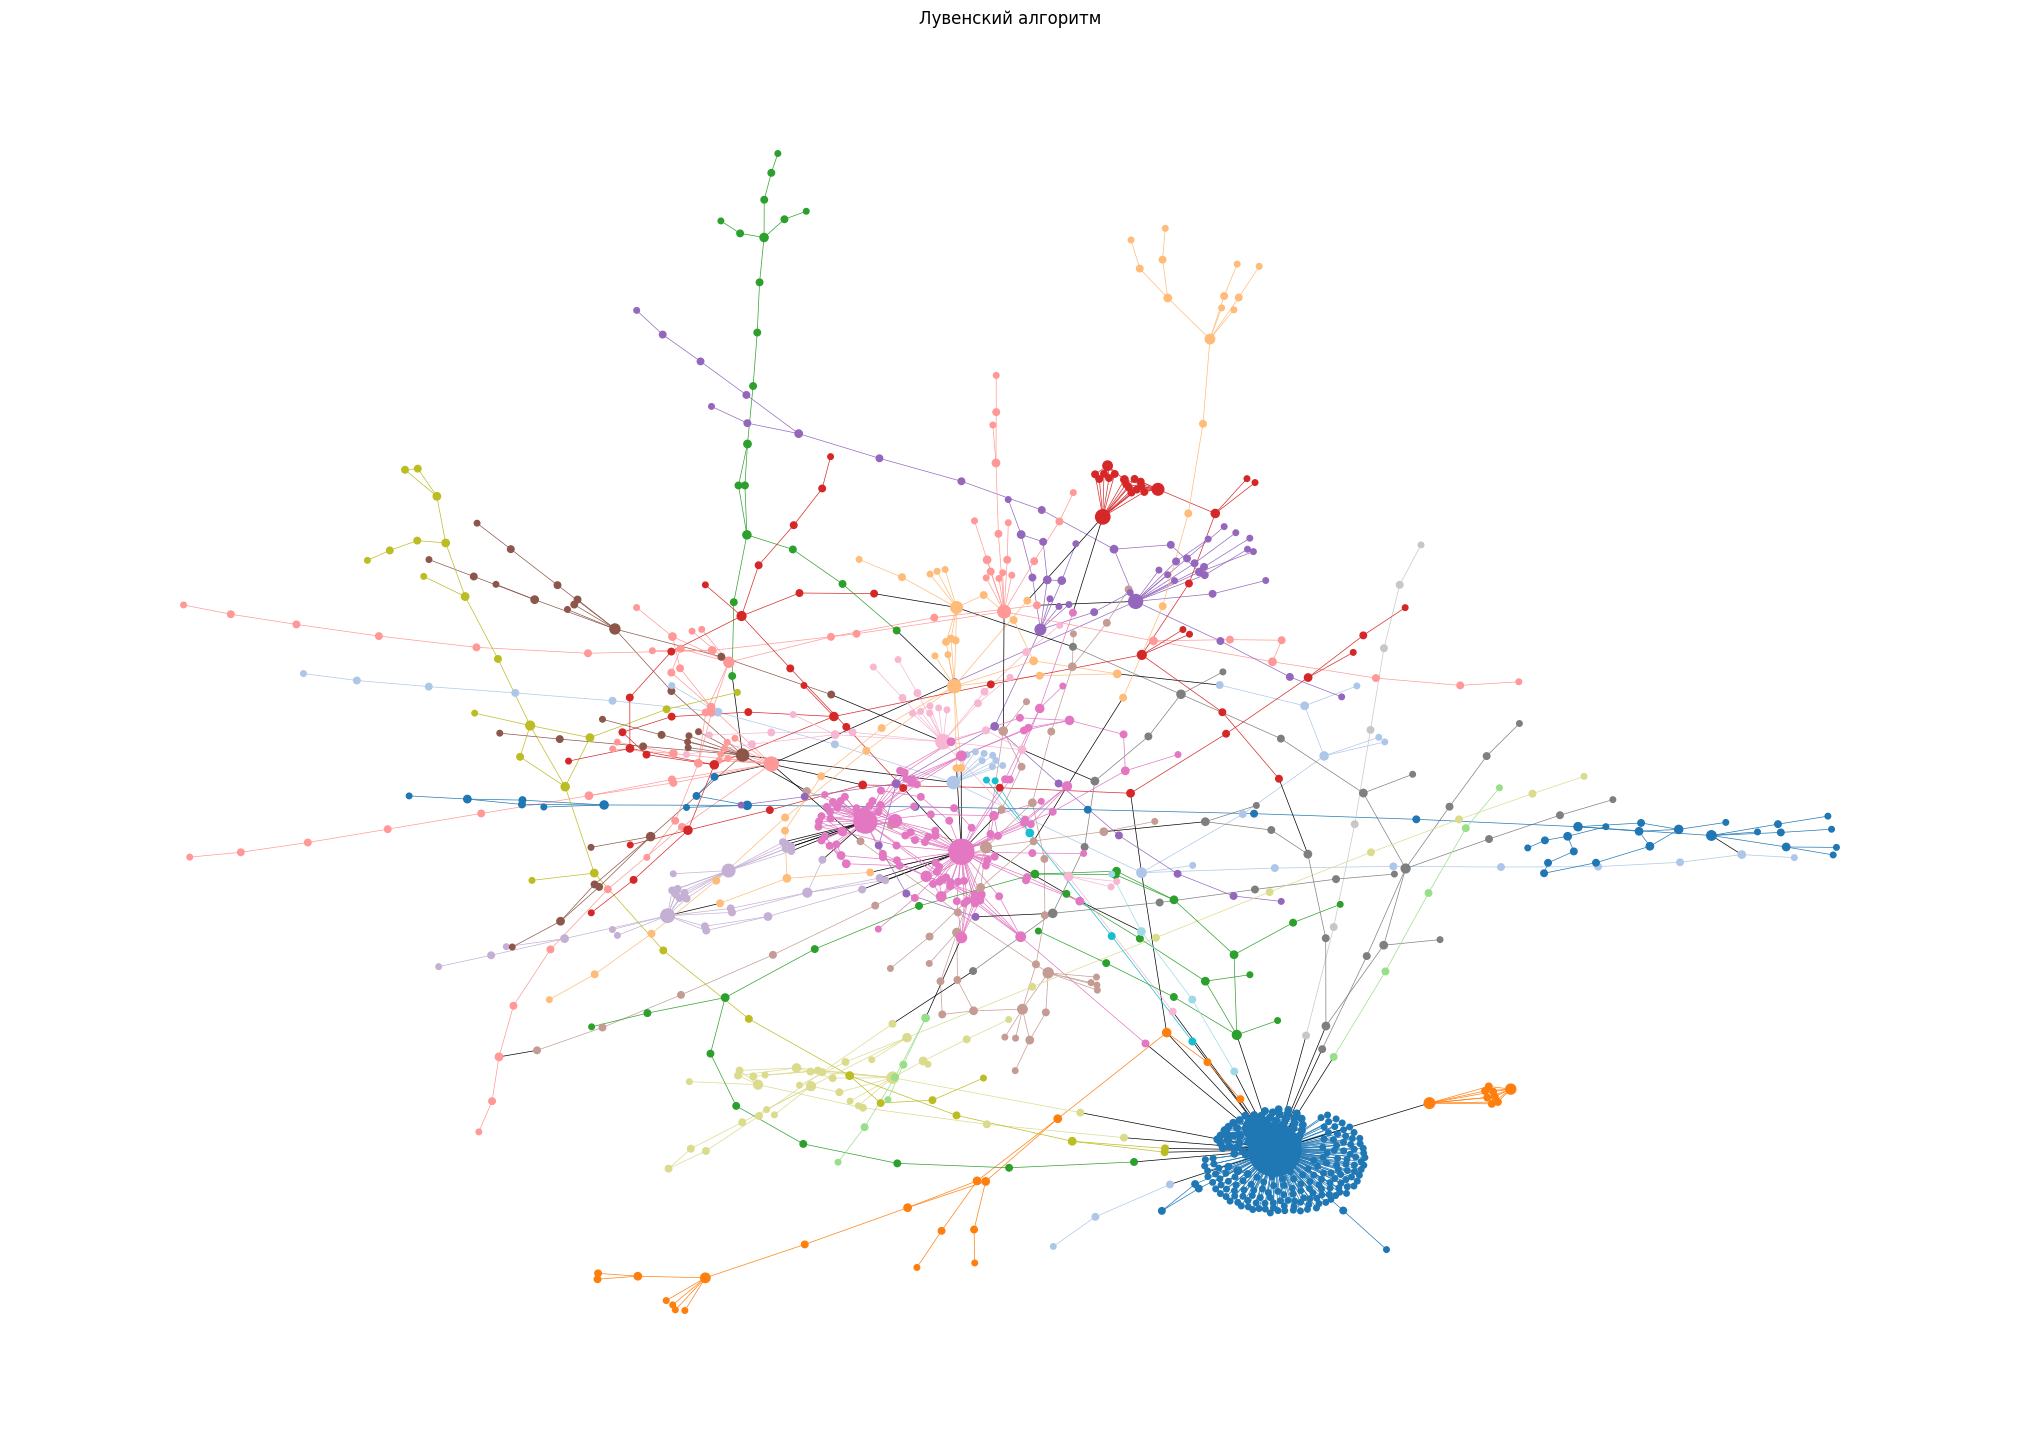

In [109]:
communities = louvain_communities(G)

colors = plt.cm.tab20.colors

node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title("Лувенский алгоритм")
plt.show()

In [110]:
# метка для каждой вершины узел:метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['Лувенский алгоритм',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.8473300735276275
Коэффициент силуэта: 0.3269508
Индекс Калински-Харабаша: 75.03647009551801
Индекс Дэвиcа-Боулдина: 1.2478429652994294


## 2) Алгоритм Гирвана-Ньюмена

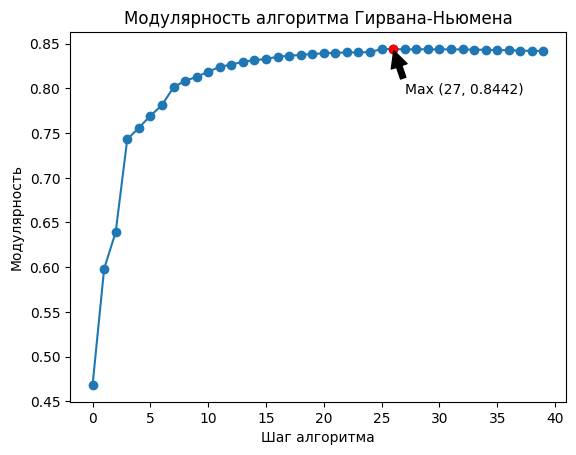

In [111]:
communities_generator = girvan_newman(G)

modularity_values = []
optimal_communities_gn = []
max_modularity_index = None
counter = 0

for i, communities in enumerate(communities_generator):
    current_modularity = modularity(G, communities)
    modularity_values.append(current_modularity)

    if max_modularity_index is None or current_modularity > modularity_values[max_modularity_index]:
        max_modularity_index = i
        optimal_communities_gn = communities

    counter += 1
    if counter >= 40:
        break

plt.plot(modularity_values, marker='o')
plt.xlabel("Шаг алгоритма")
plt.ylabel("Модулярность")
plt.title("Модулярность алгоритма Гирвана-Ньюмена")

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index, modularity_values[max_modularity_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_modularity_index + 1}, {modularity_values[max_modularity_index]:.4f})',
             xy=(max_modularity_index, modularity_values[max_modularity_index]),
             xytext=(max_modularity_index + 1, modularity_values[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

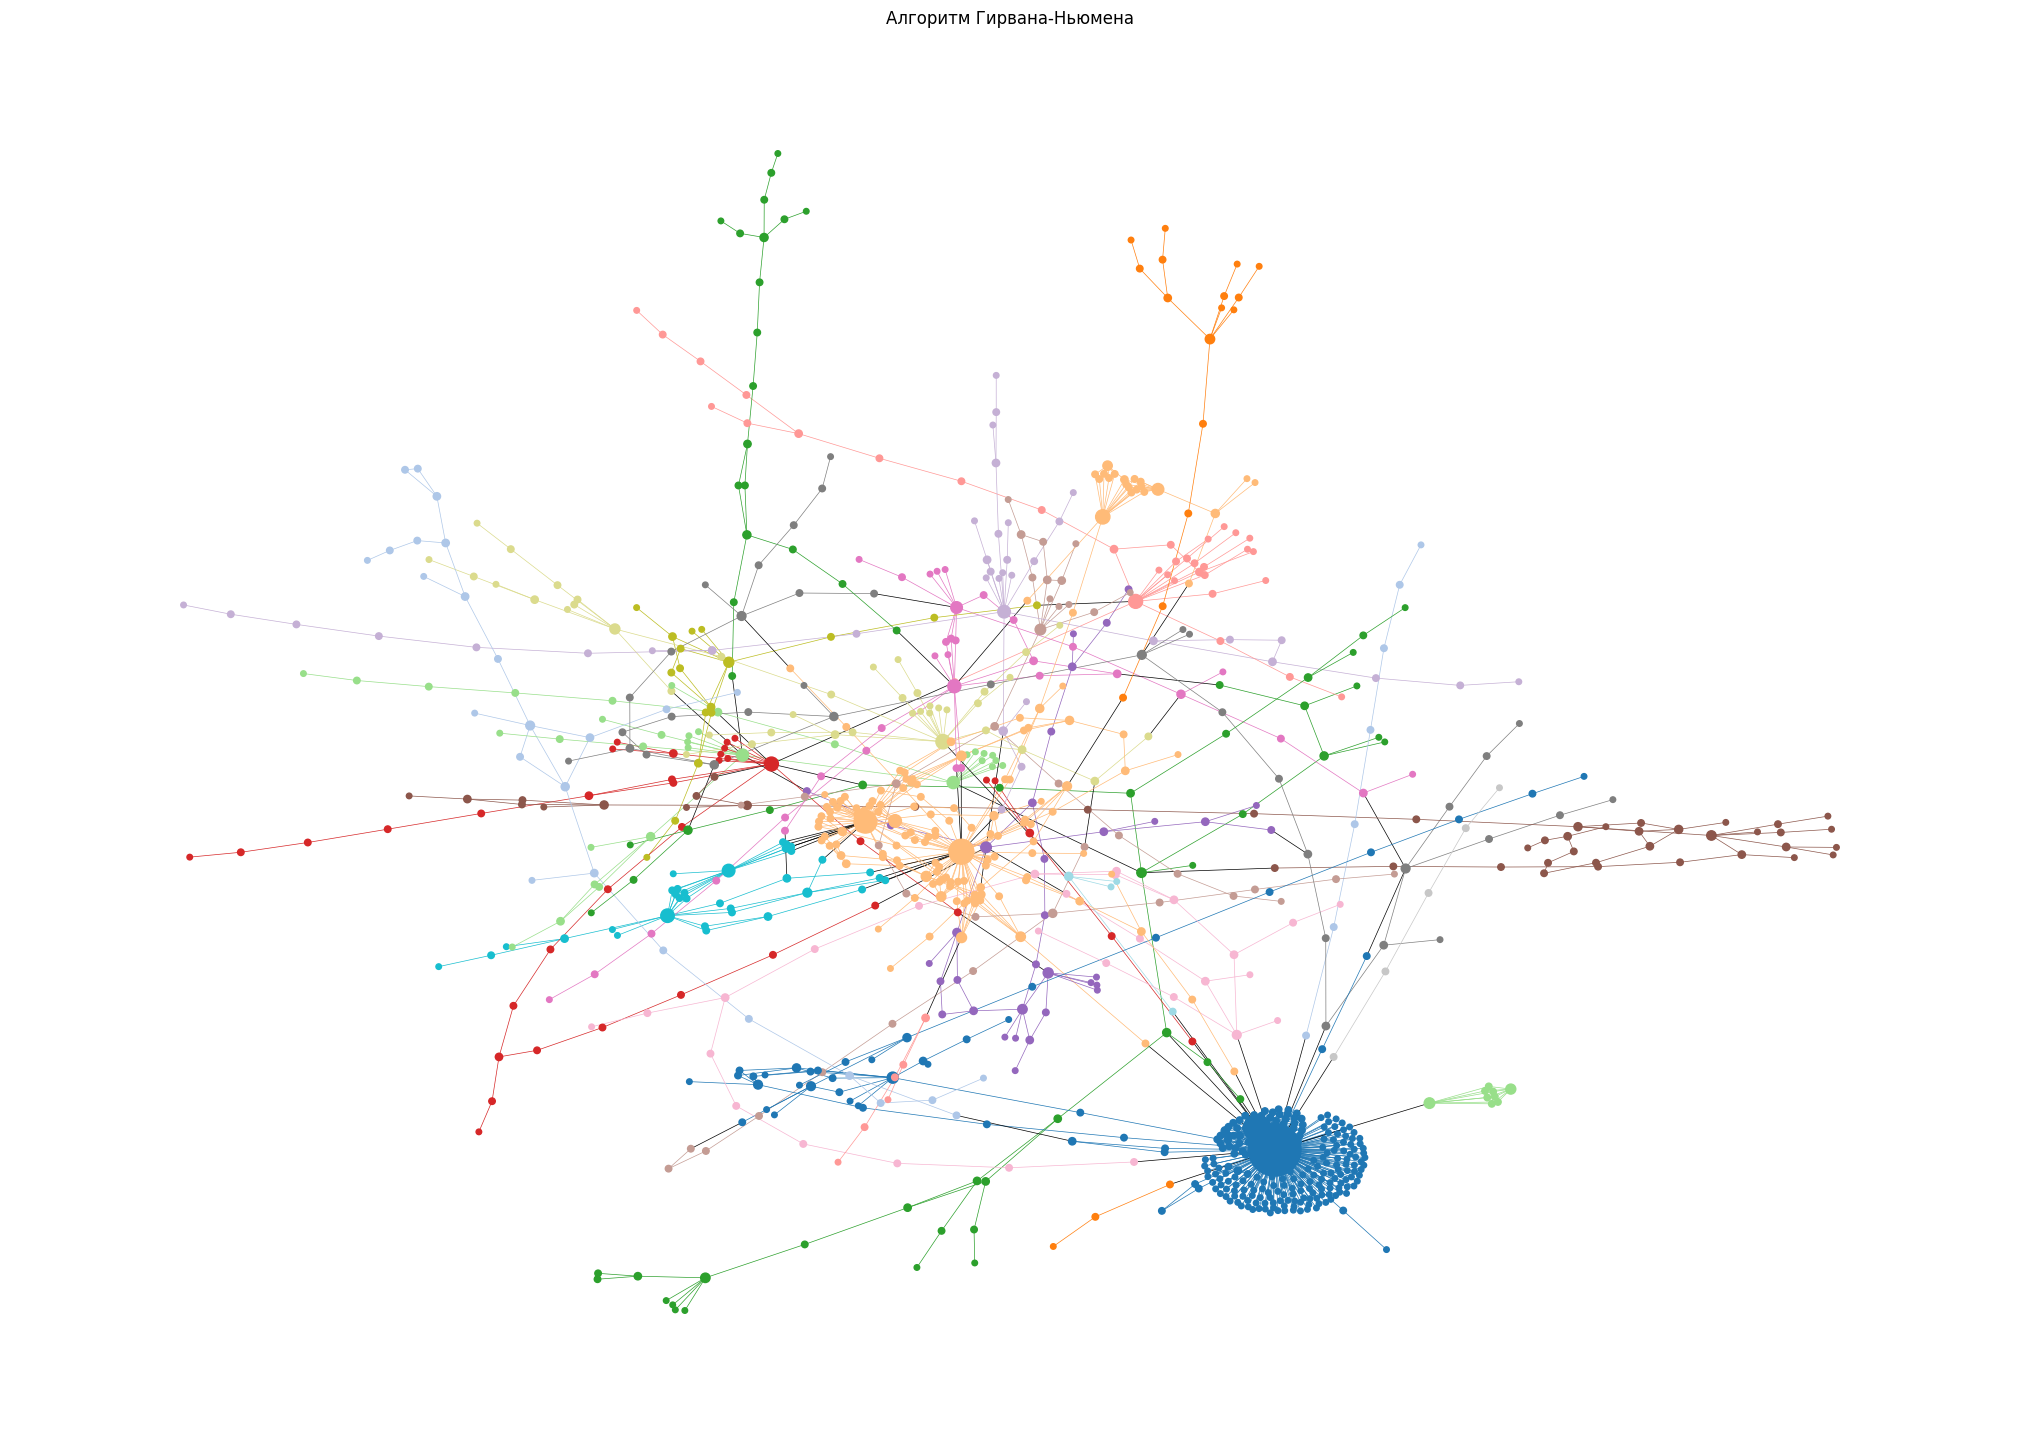

In [112]:
colors = plt.cm.tab20.colors

node_color_dict = {}
for i, community in enumerate(optimal_communities_gn):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title(f"Алгоритм Гирвана-Ньюмена")
plt.show()

In [113]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(optimal_communities_gn):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

modularity_value = modularity(G, optimal_communities_gn)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['Алгоритм Гирвана-Ньюмена',
                             len(optimal_communities_gn),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.8442263151792626
Коэффициент силуэта: 0.31368947
Индекс Калински-Харабаша: 72.70709372853024
Индекс Дэвиcа-Боулдина: 1.3014669986950407


## 3) Greedy Modularity Maximization

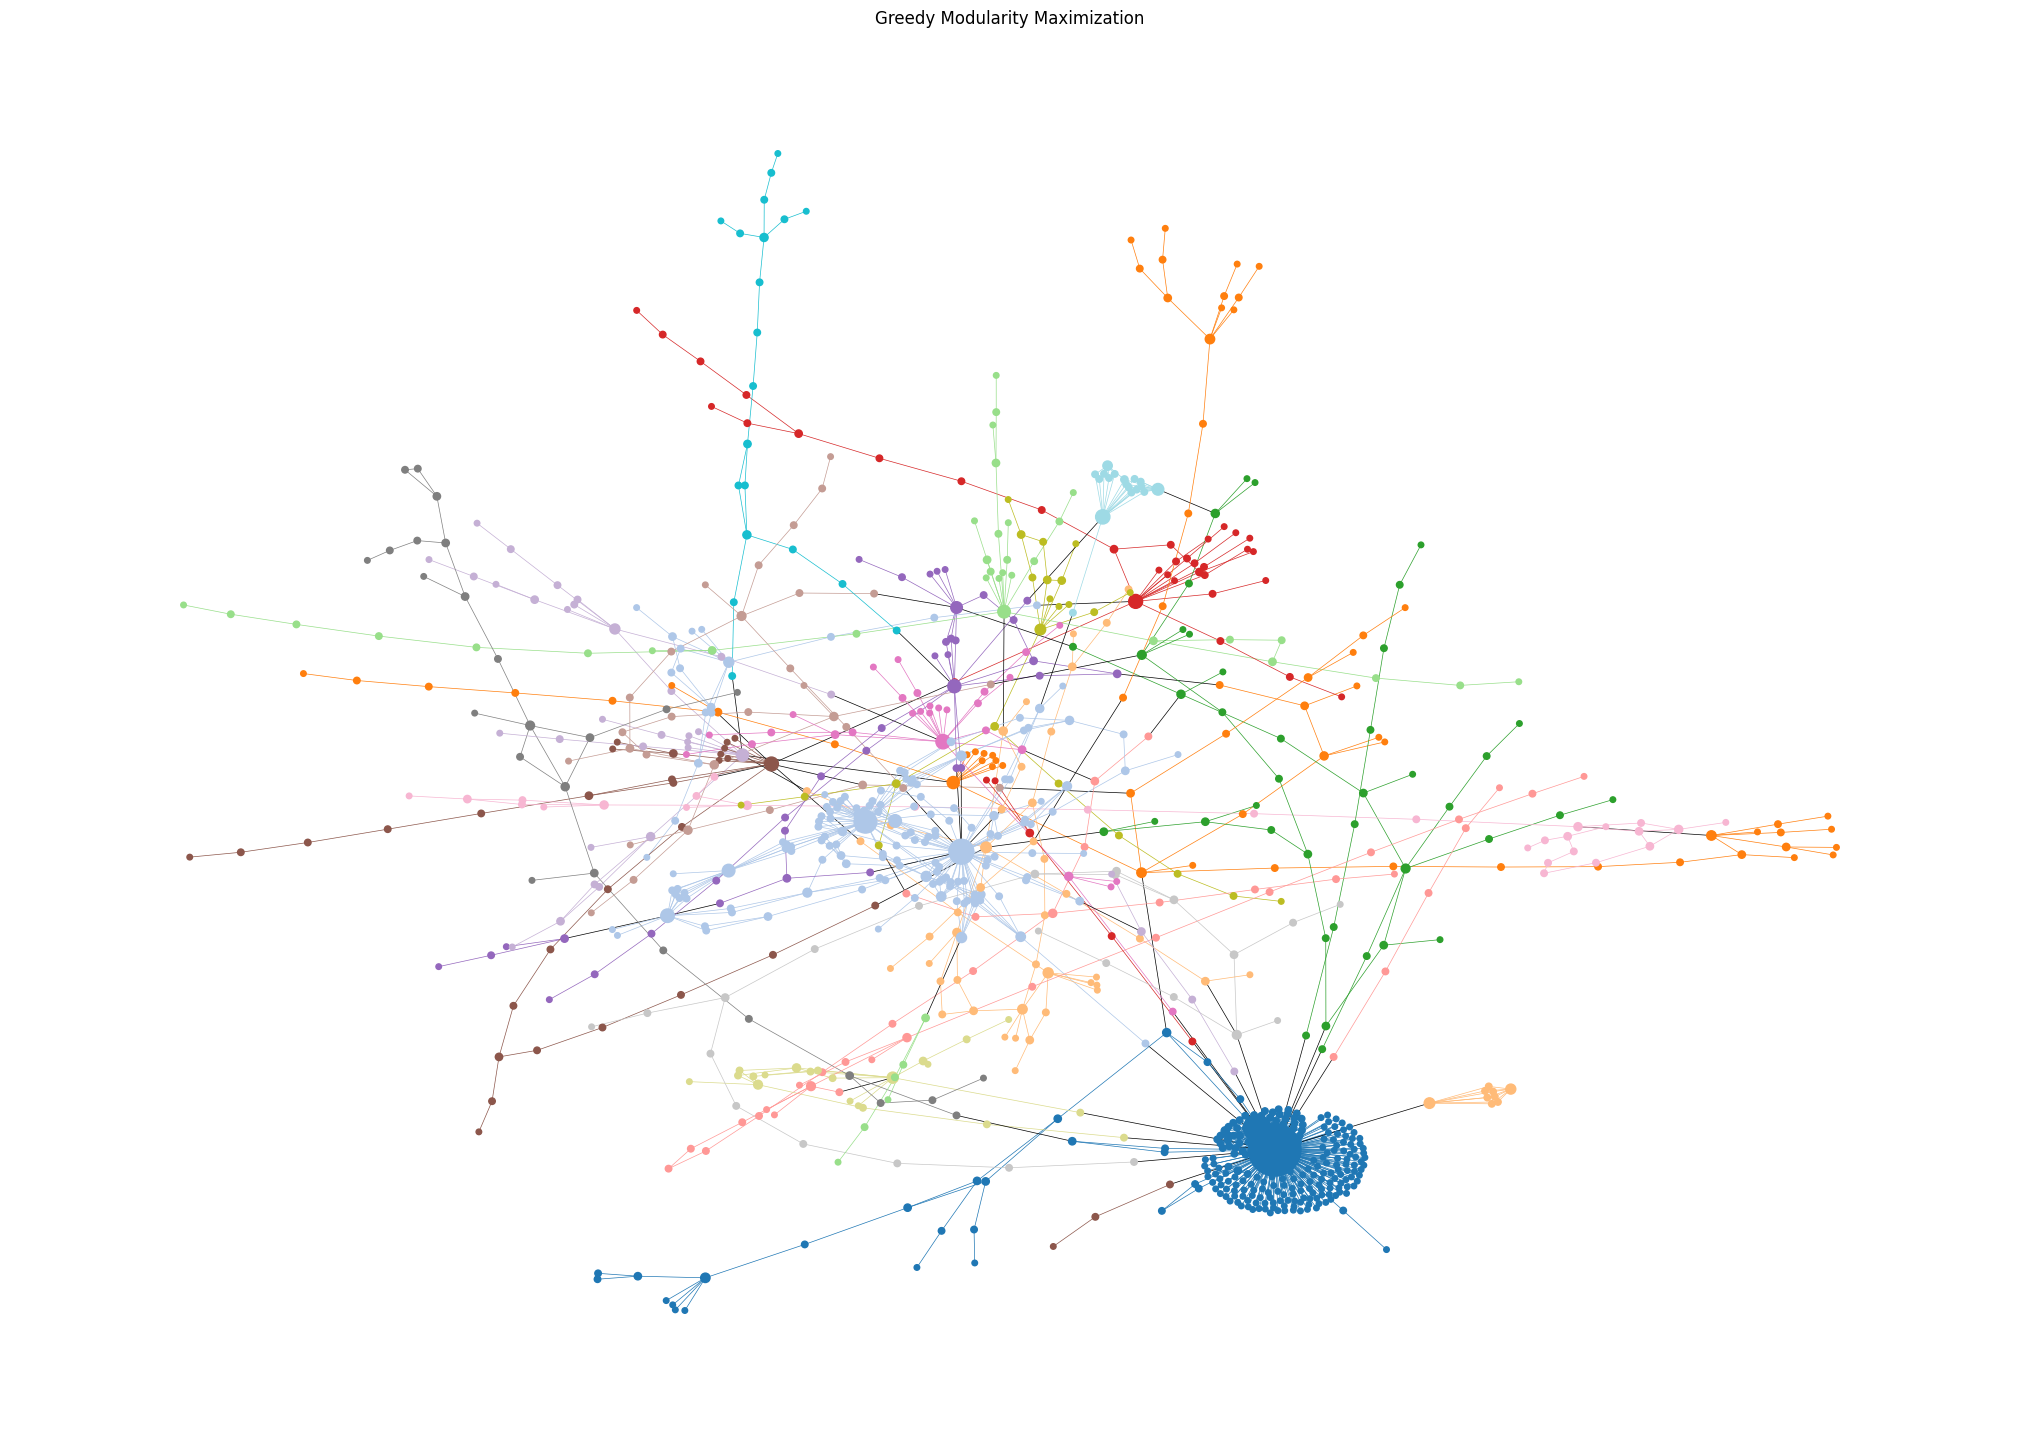

In [114]:
communities = greedy_modularity_communities(G)

colors = plt.cm.tab20.colors
node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title("Greedy Modularity Maximization")
plt.show()

In [115]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список емток
labels = [node_to_community[node] for node in G.nodes()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['Greedy Modularity Maximization',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.8437322213863746
Коэффициент силуэта: 0.3380317
Индекс Калински-Харабаша: 72.64585393439297
Индекс Дэвиcа-Боулдина: 1.2137847863290863


## 4) Asynchronous LPA

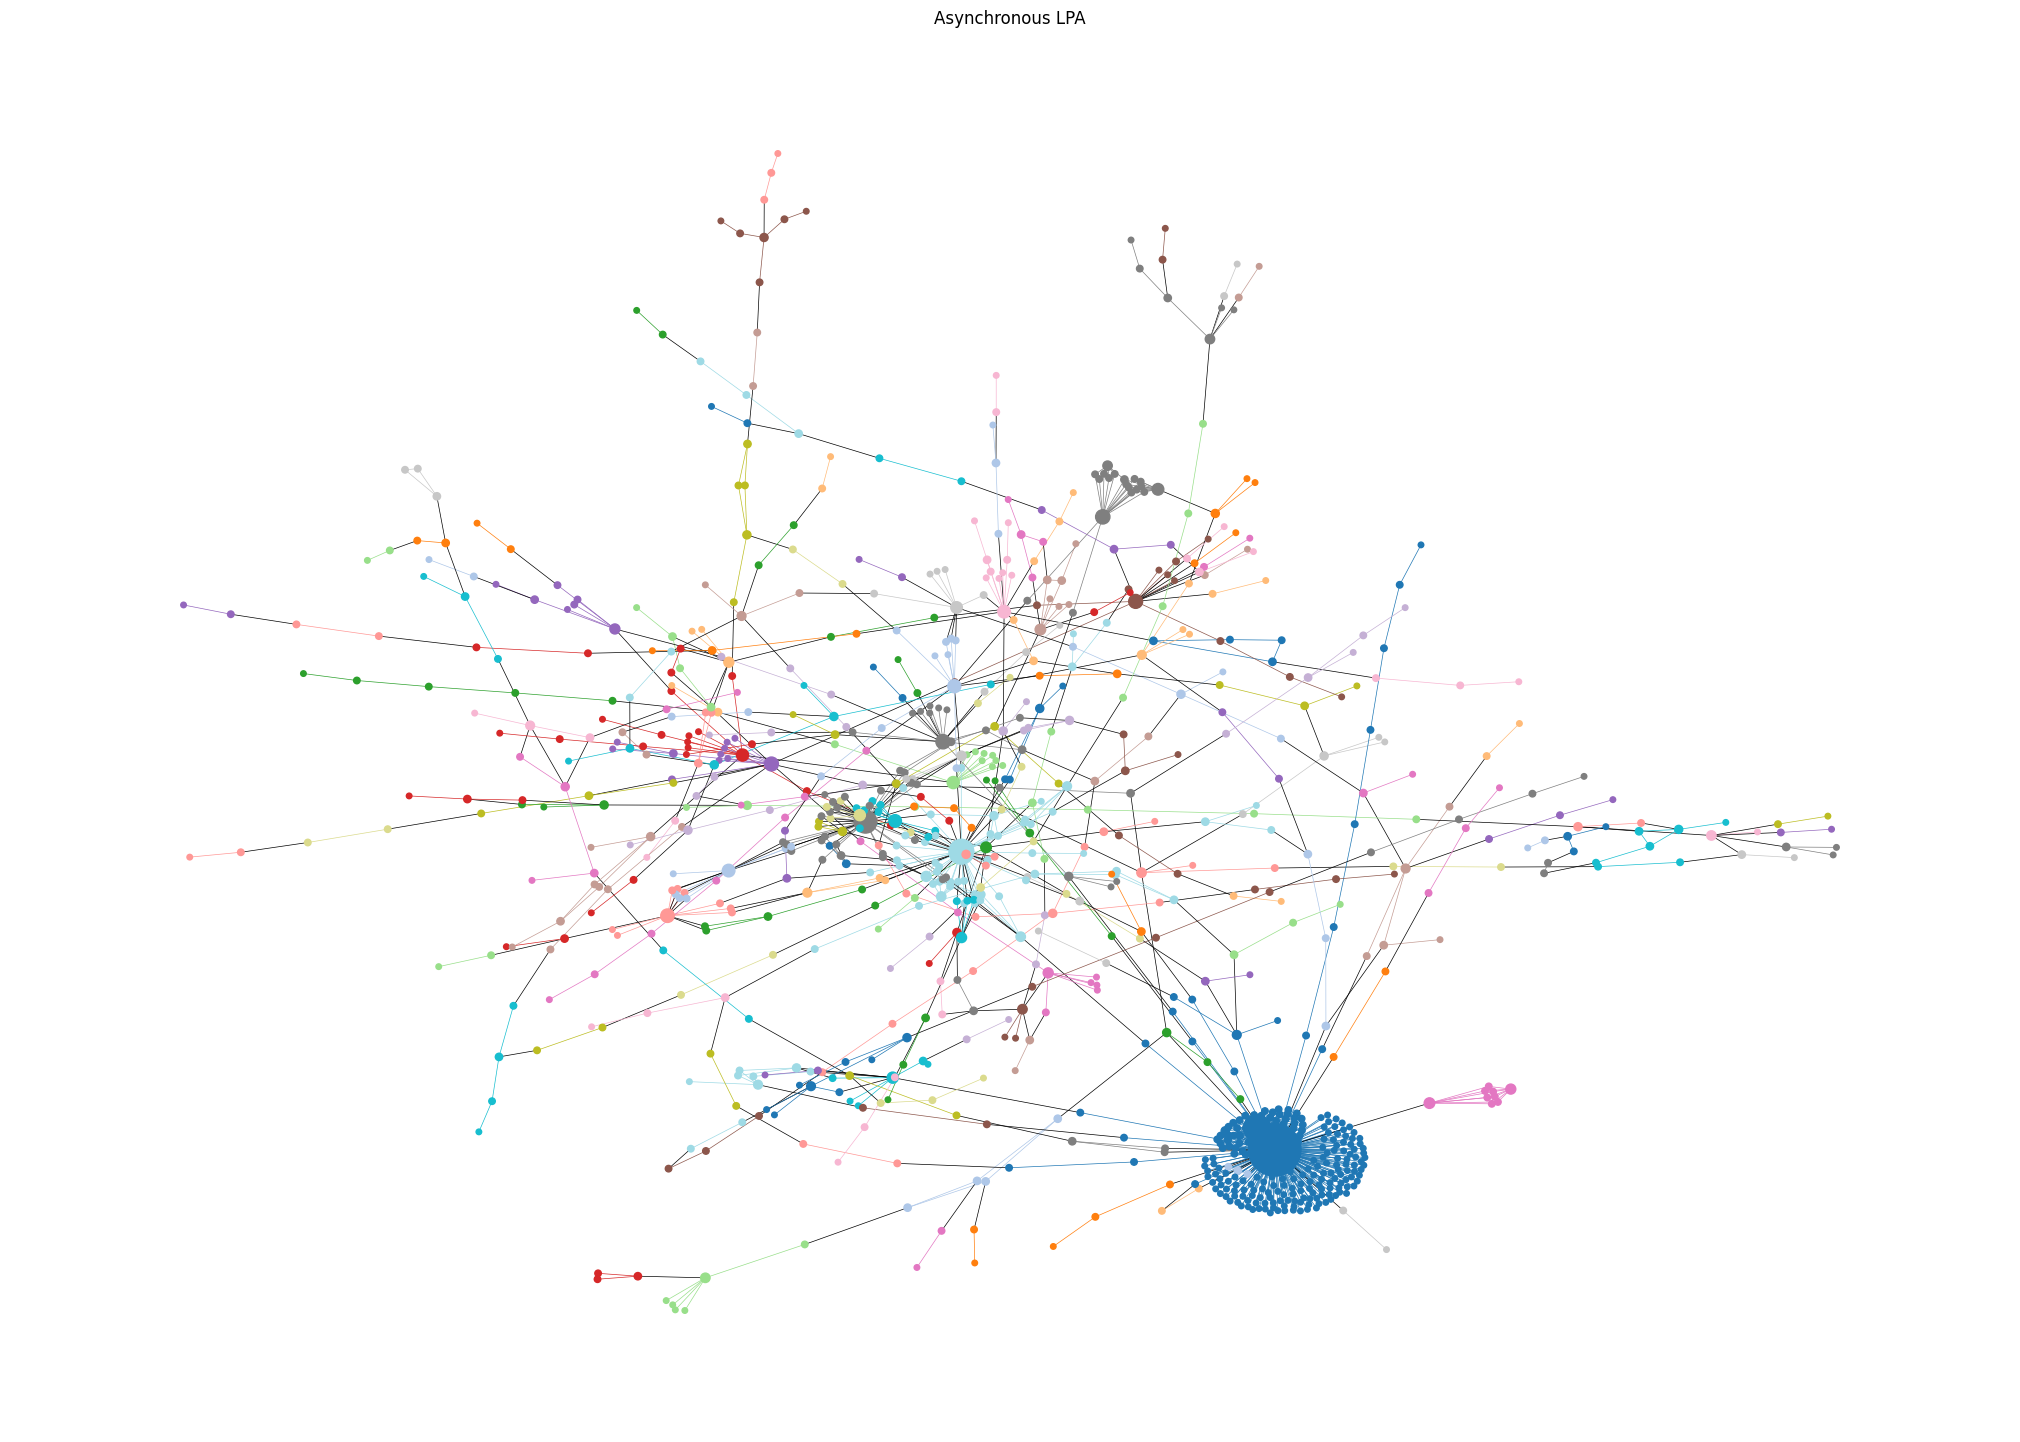

In [116]:
communities = list(asyn_lpa_communities(G))

colors = plt.cm.tab20.colors
node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Asynchronous LPA')
plt.show()

In [117]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['Asynchronous LPA',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.6619481720551892
Коэффициент силуэта: 0.301079
Индекс Калински-Харабаша: 50.68581218995949
Индекс Дэвиcа-Боулдина: 0.8807813285176221


## 5) Synchronous LPA

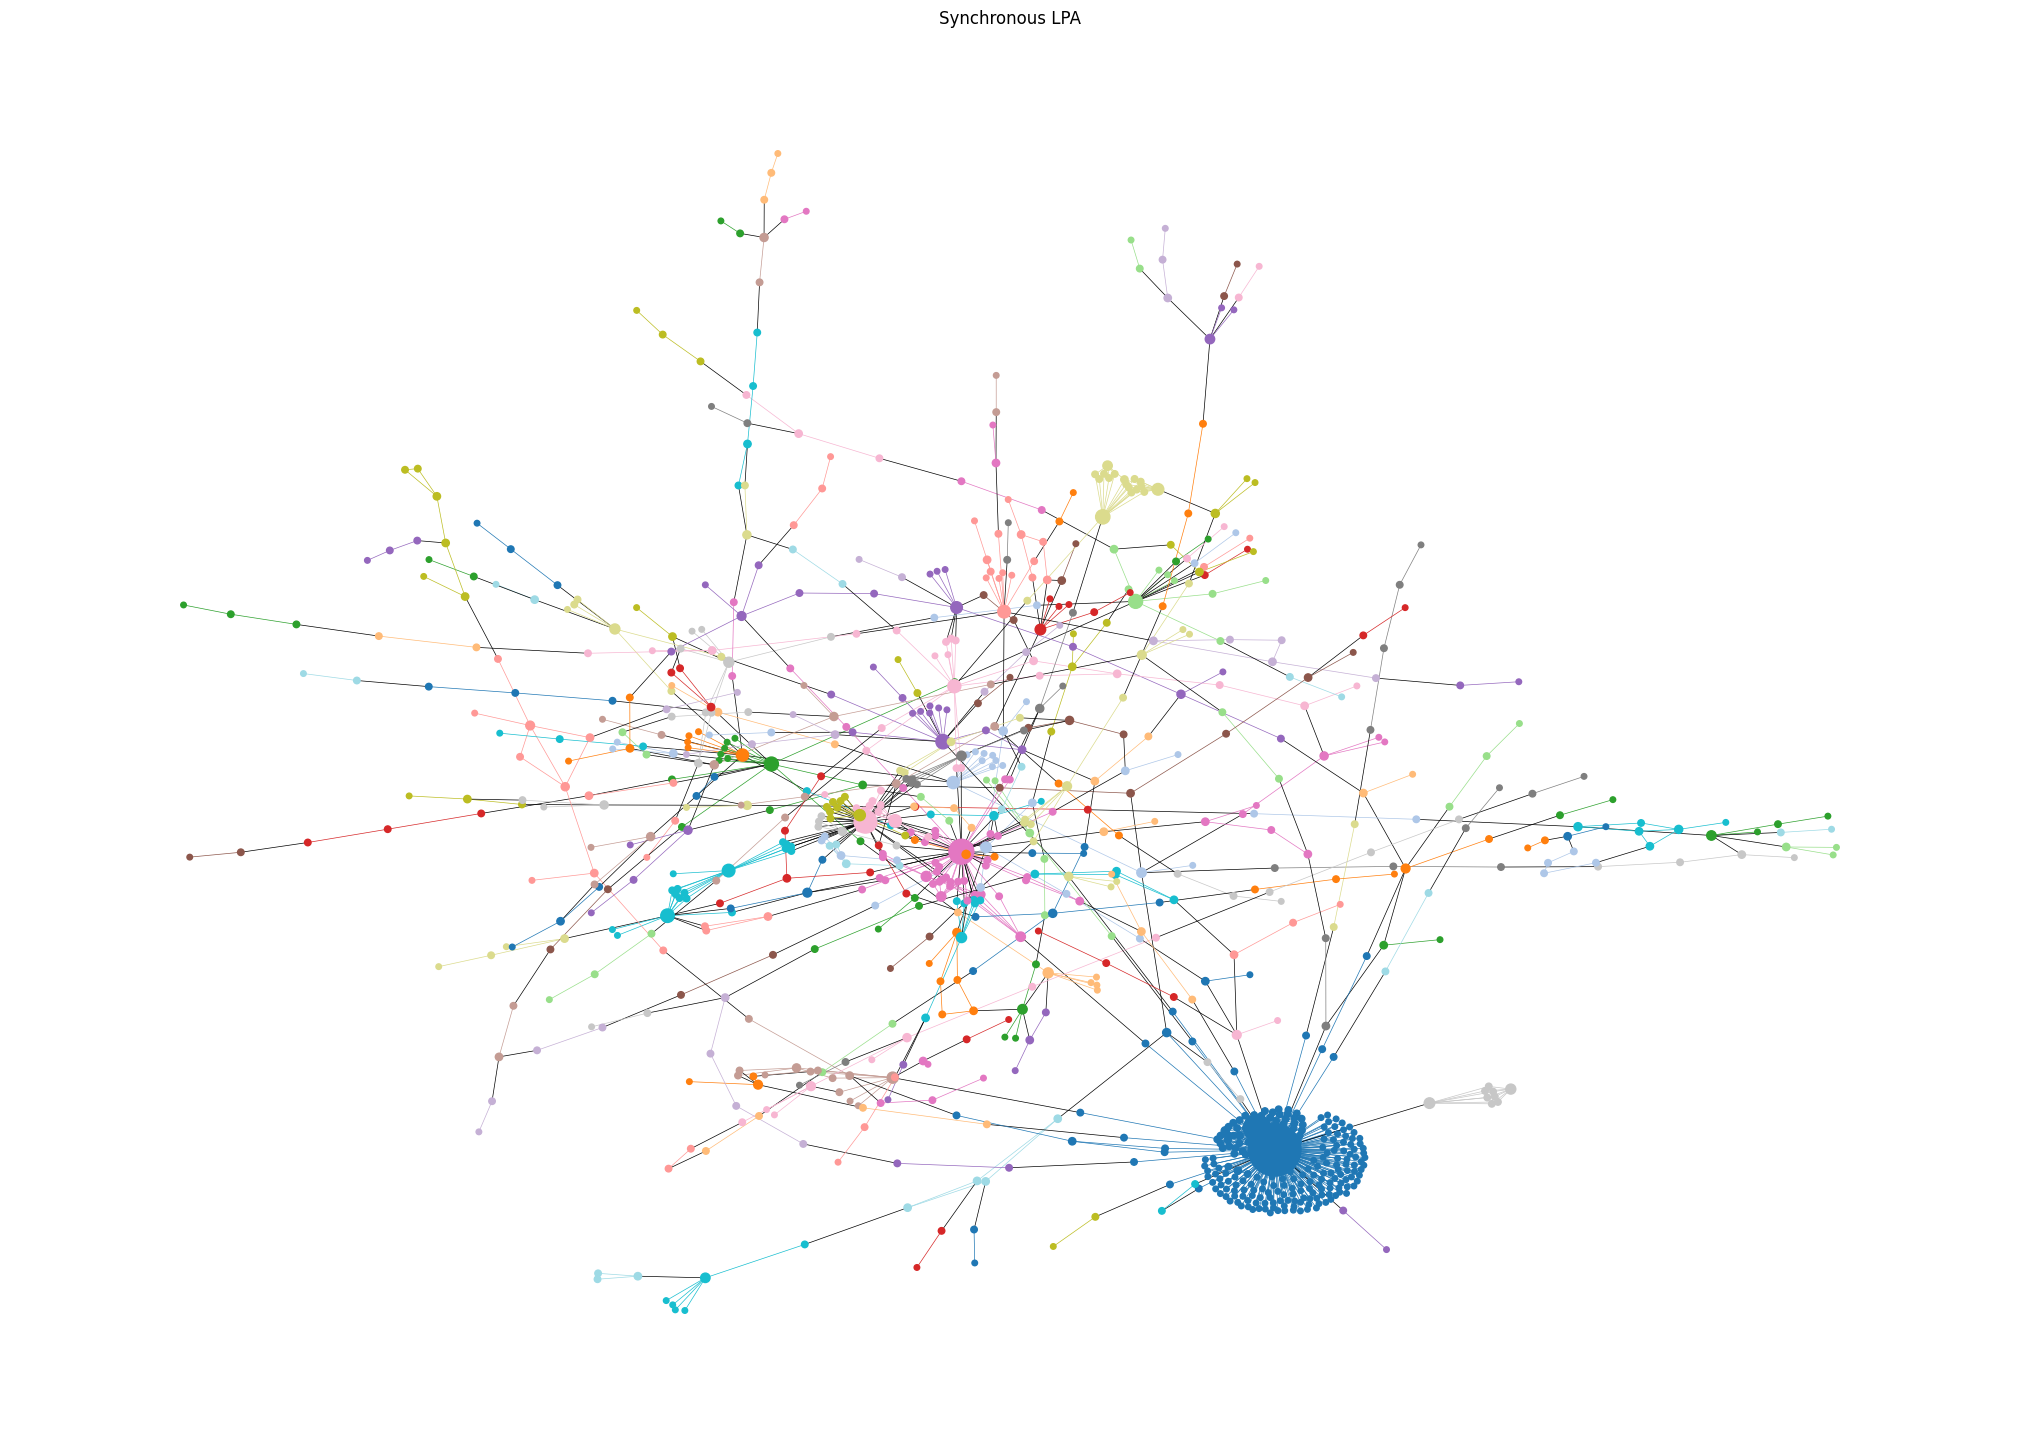

In [118]:
communities = list(label_propagation_communities(G))

colors = plt.cm.tab20.colors
node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Synchronous LPA')
plt.show()

In [119]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['Synchronous LPA',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.6747791070451188
Коэффициент силуэта: 0.33172005
Индекс Калински-Харабаша: 53.38016129404002
Индекс Дэвиcа-Боулдина: 0.8466611770113455


## 6) Fluid Communities

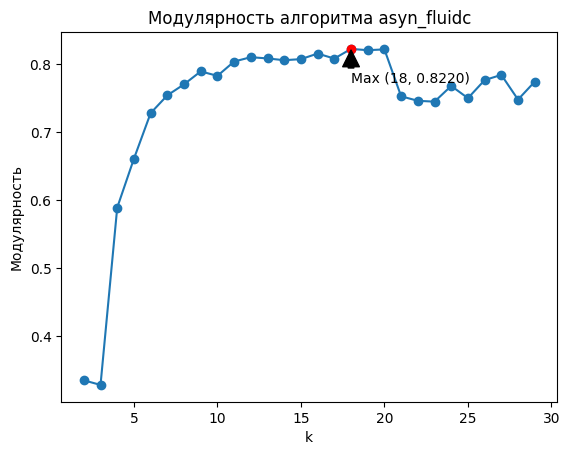

In [120]:
modularity_values = []
optimal_communities = []
max_modularity_index = None

for k in range(2, 30):
    communities = asyn_fluidc(G, k=k, seed=63)

    modularity_value = modularity(G, communities)
    modularity_values.append(modularity_value)

    if max_modularity_index is None or modularity_value > modularity_values[max_modularity_index]:
        max_modularity_index = k - 2
        optimal_communities = communities

plt.plot(range(2, 30), modularity_values, marker='o')
plt.xlabel("k")
plt.ylabel("Модулярность")
plt.title("Модулярность алгоритма asyn_fluidc")

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index + 2, modularity_values[max_modularity_index], 'ro')

# Вывод оптимальной точки с аннотацией
plt.annotate(f'Max ({max_modularity_index + 2}, {modularity_values[max_modularity_index]:.4f})',
             xy=(max_modularity_index + 2, modularity_values[max_modularity_index]),
             xytext=(max_modularity_index + 2, modularity_values[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

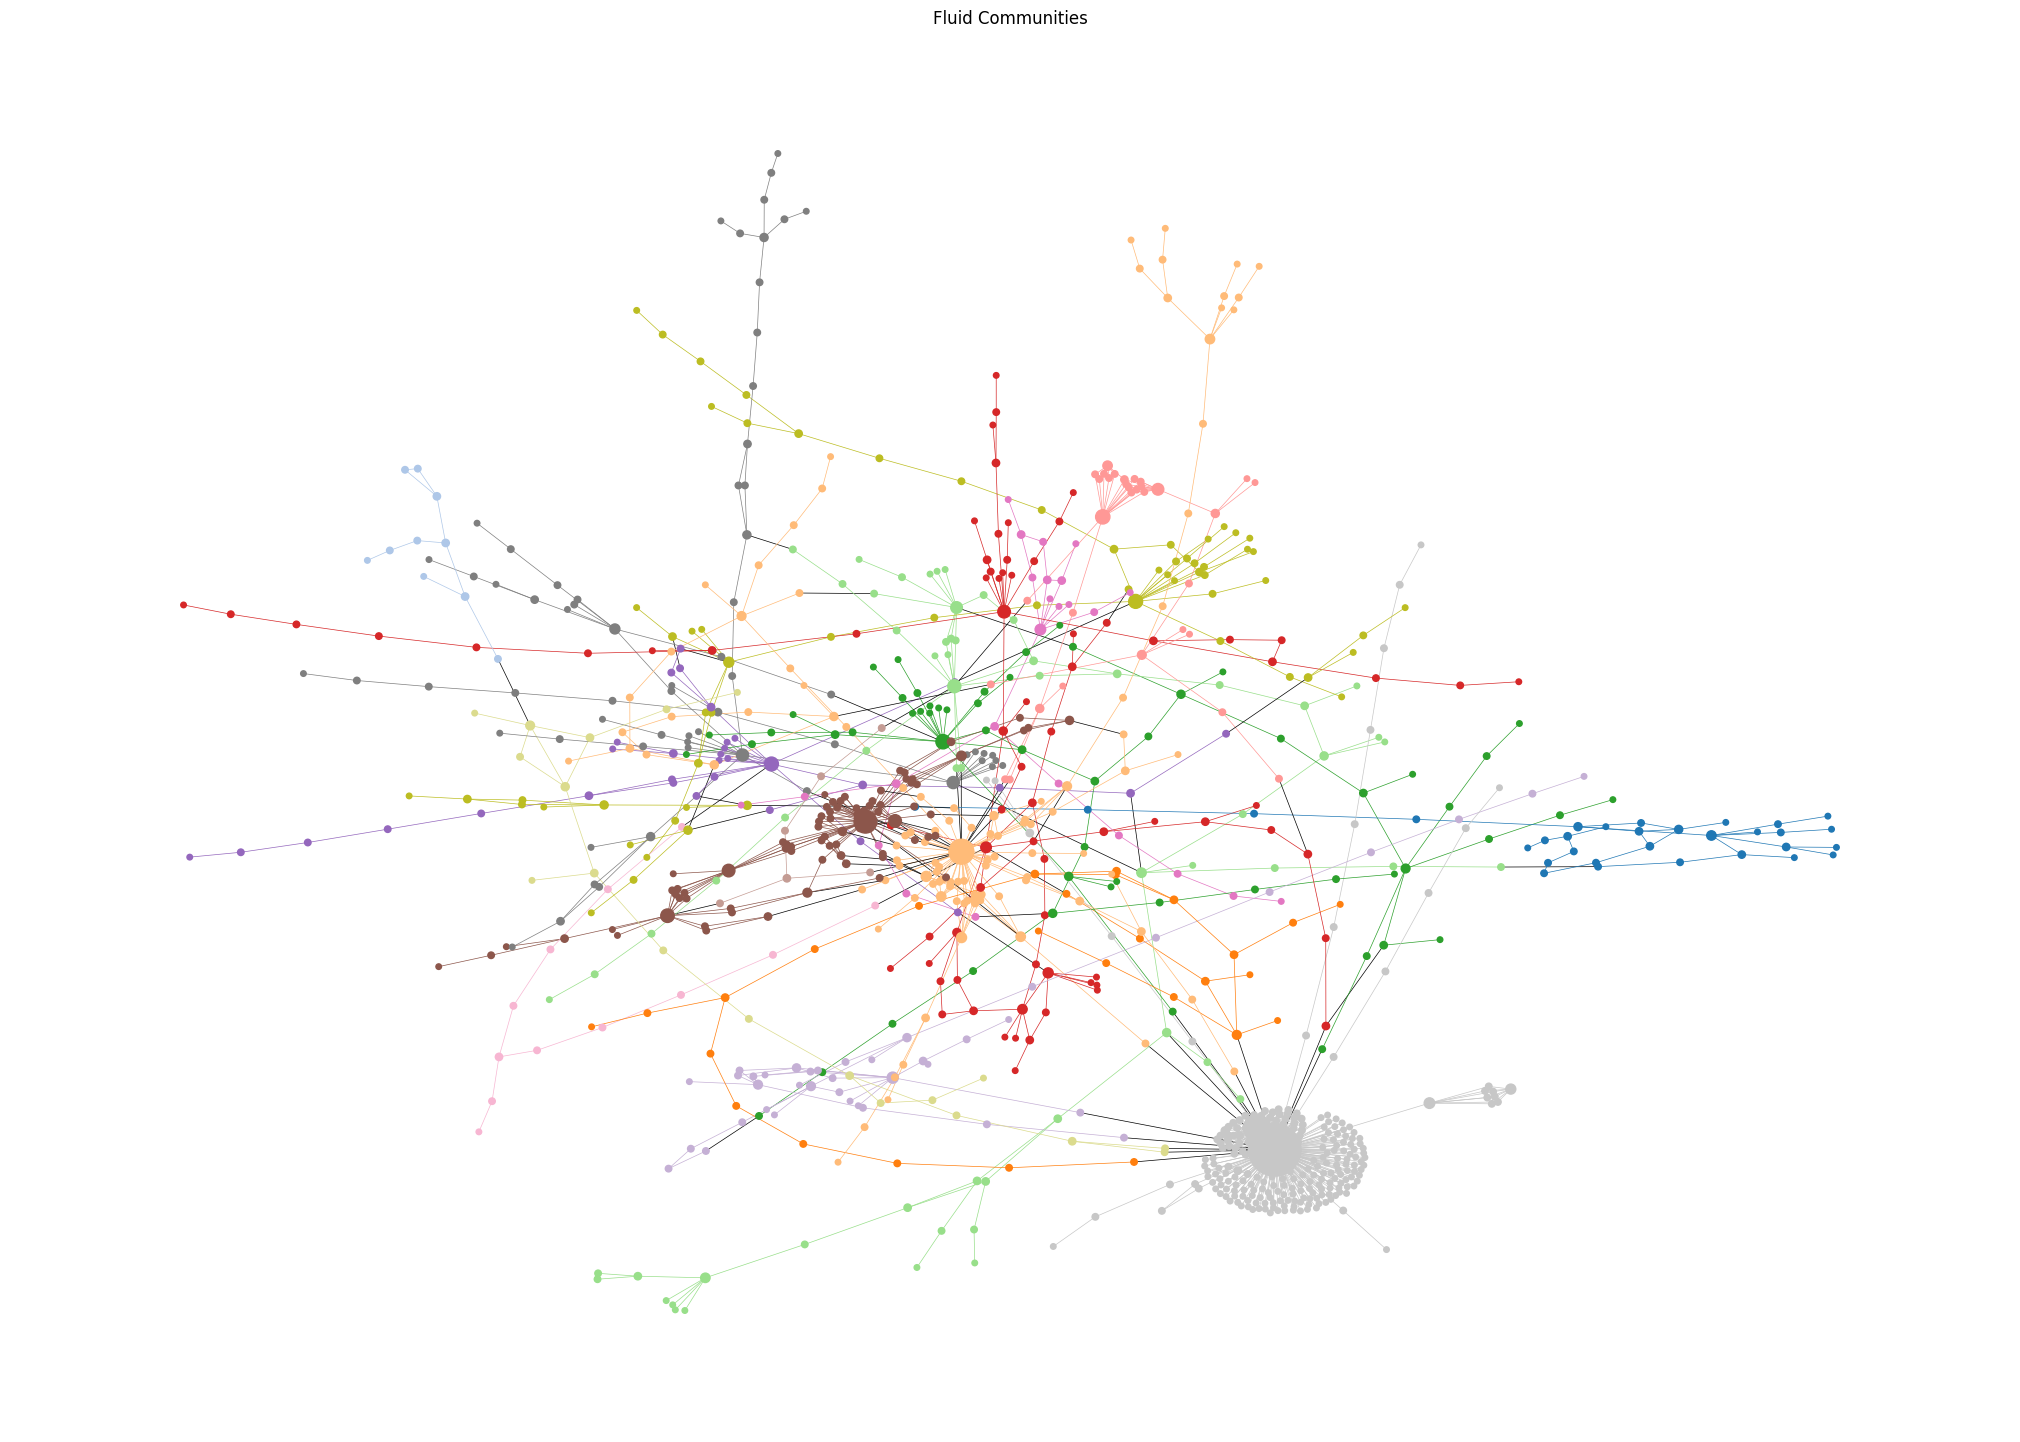

In [121]:
communities = list(asyn_fluidc(G, k=18, seed=63))

colors = plt.cm.tab20.colors
node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Fluid Communities')
plt.show()

In [122]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['Fluid Communities',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.8219658057436213
Коэффициент силуэта: 0.2626723
Индекс Калински-Харабаша: 72.43378801241111
Индекс Дэвиcа-Боулдина: 1.663710102300453


## 7) K-Means Clustering

### Метод локтя (Elbow Method)

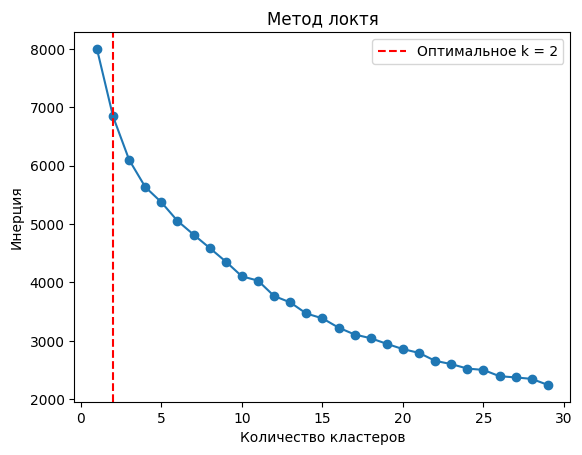

In [123]:
inertias = []

for k in range(1, 30):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(node_vectors)
    inertias.append(kmeans.inertia_)

# Вычисляем первую производную инерции
differences = np.diff(inertias)

# Вычисляем вторую производную инерции
acceleration = np.diff(differences)

# Находим индекс, где вторая производная становится максимальной
optimal_k_index = np.argmax(acceleration) + 1  # добавляем 1, так как разница в длине массива
optimal_k = optimal_k_index + 1  # добавляем 1, так как индексация начинается с 0

# Визуализируем метод локтя
plt.plot(range(1, 30), inertias, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Оптимальное k = {optimal_k}')
plt.legend()
plt.show()

### Индекс силуэта (Silhouette Score)

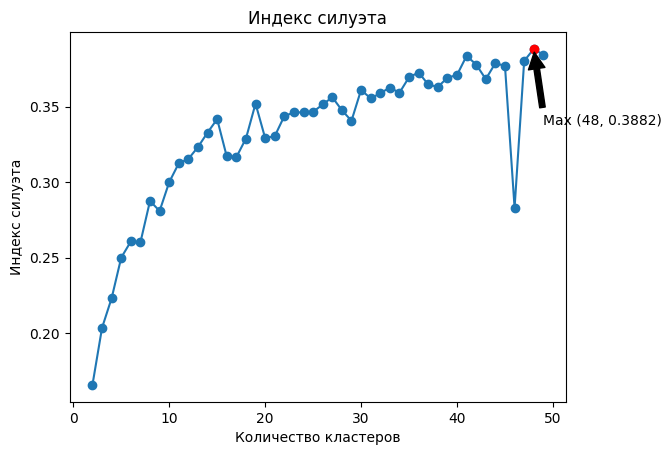

In [124]:
silhouette_scores = []

for k in range(2, 50):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(node_vectors)
    silhouette = silhouette_score(node_vectors, kmeans.labels_)
    silhouette_scores.append(silhouette)

plt.plot(range(2, 50), silhouette_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Индекс силуэта')
plt.title('Индекс силуэта')

# Находим индекс максимального значения силуэта
max_silhouette_index = silhouette_scores.index(max(silhouette_scores))

# Добавляем красную точку для максимального значения силуэта
plt.plot(max_silhouette_index + 2, silhouette_scores[max_silhouette_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_silhouette_index + 2}, {silhouette_scores[max_silhouette_index]:.4f})',
             xy=(max_silhouette_index + 2, silhouette_scores[max_silhouette_index]),
             xytext=(max_silhouette_index + 3, silhouette_scores[max_silhouette_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

### Модулярность

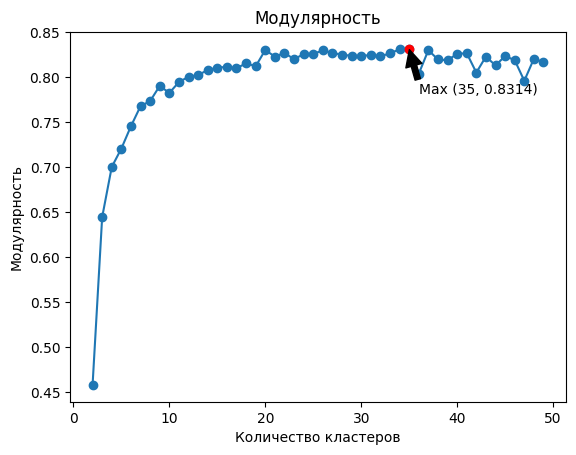

In [125]:
modularity_scores = []

for k in range(2, 50):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(node_vectors)
    labels = kmeans.labels_
    partition = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(k)]
    modularity_scores.append(modularity(G, partition))

plt.plot(range(2, 50), modularity_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Модулярность')
plt.title('Модулярность')

# Находим индекс максимального значения модулярности
max_modularity_index = modularity_scores.index(max(modularity_scores))

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index + 2, modularity_scores[max_modularity_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_modularity_index + 2}, {modularity_scores[max_modularity_index]:.4f})',
             xy=(max_modularity_index + 2, modularity_scores[max_modularity_index]),
             xytext=(max_modularity_index + 3, modularity_scores[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.02))

plt.show()

### Кластеризация

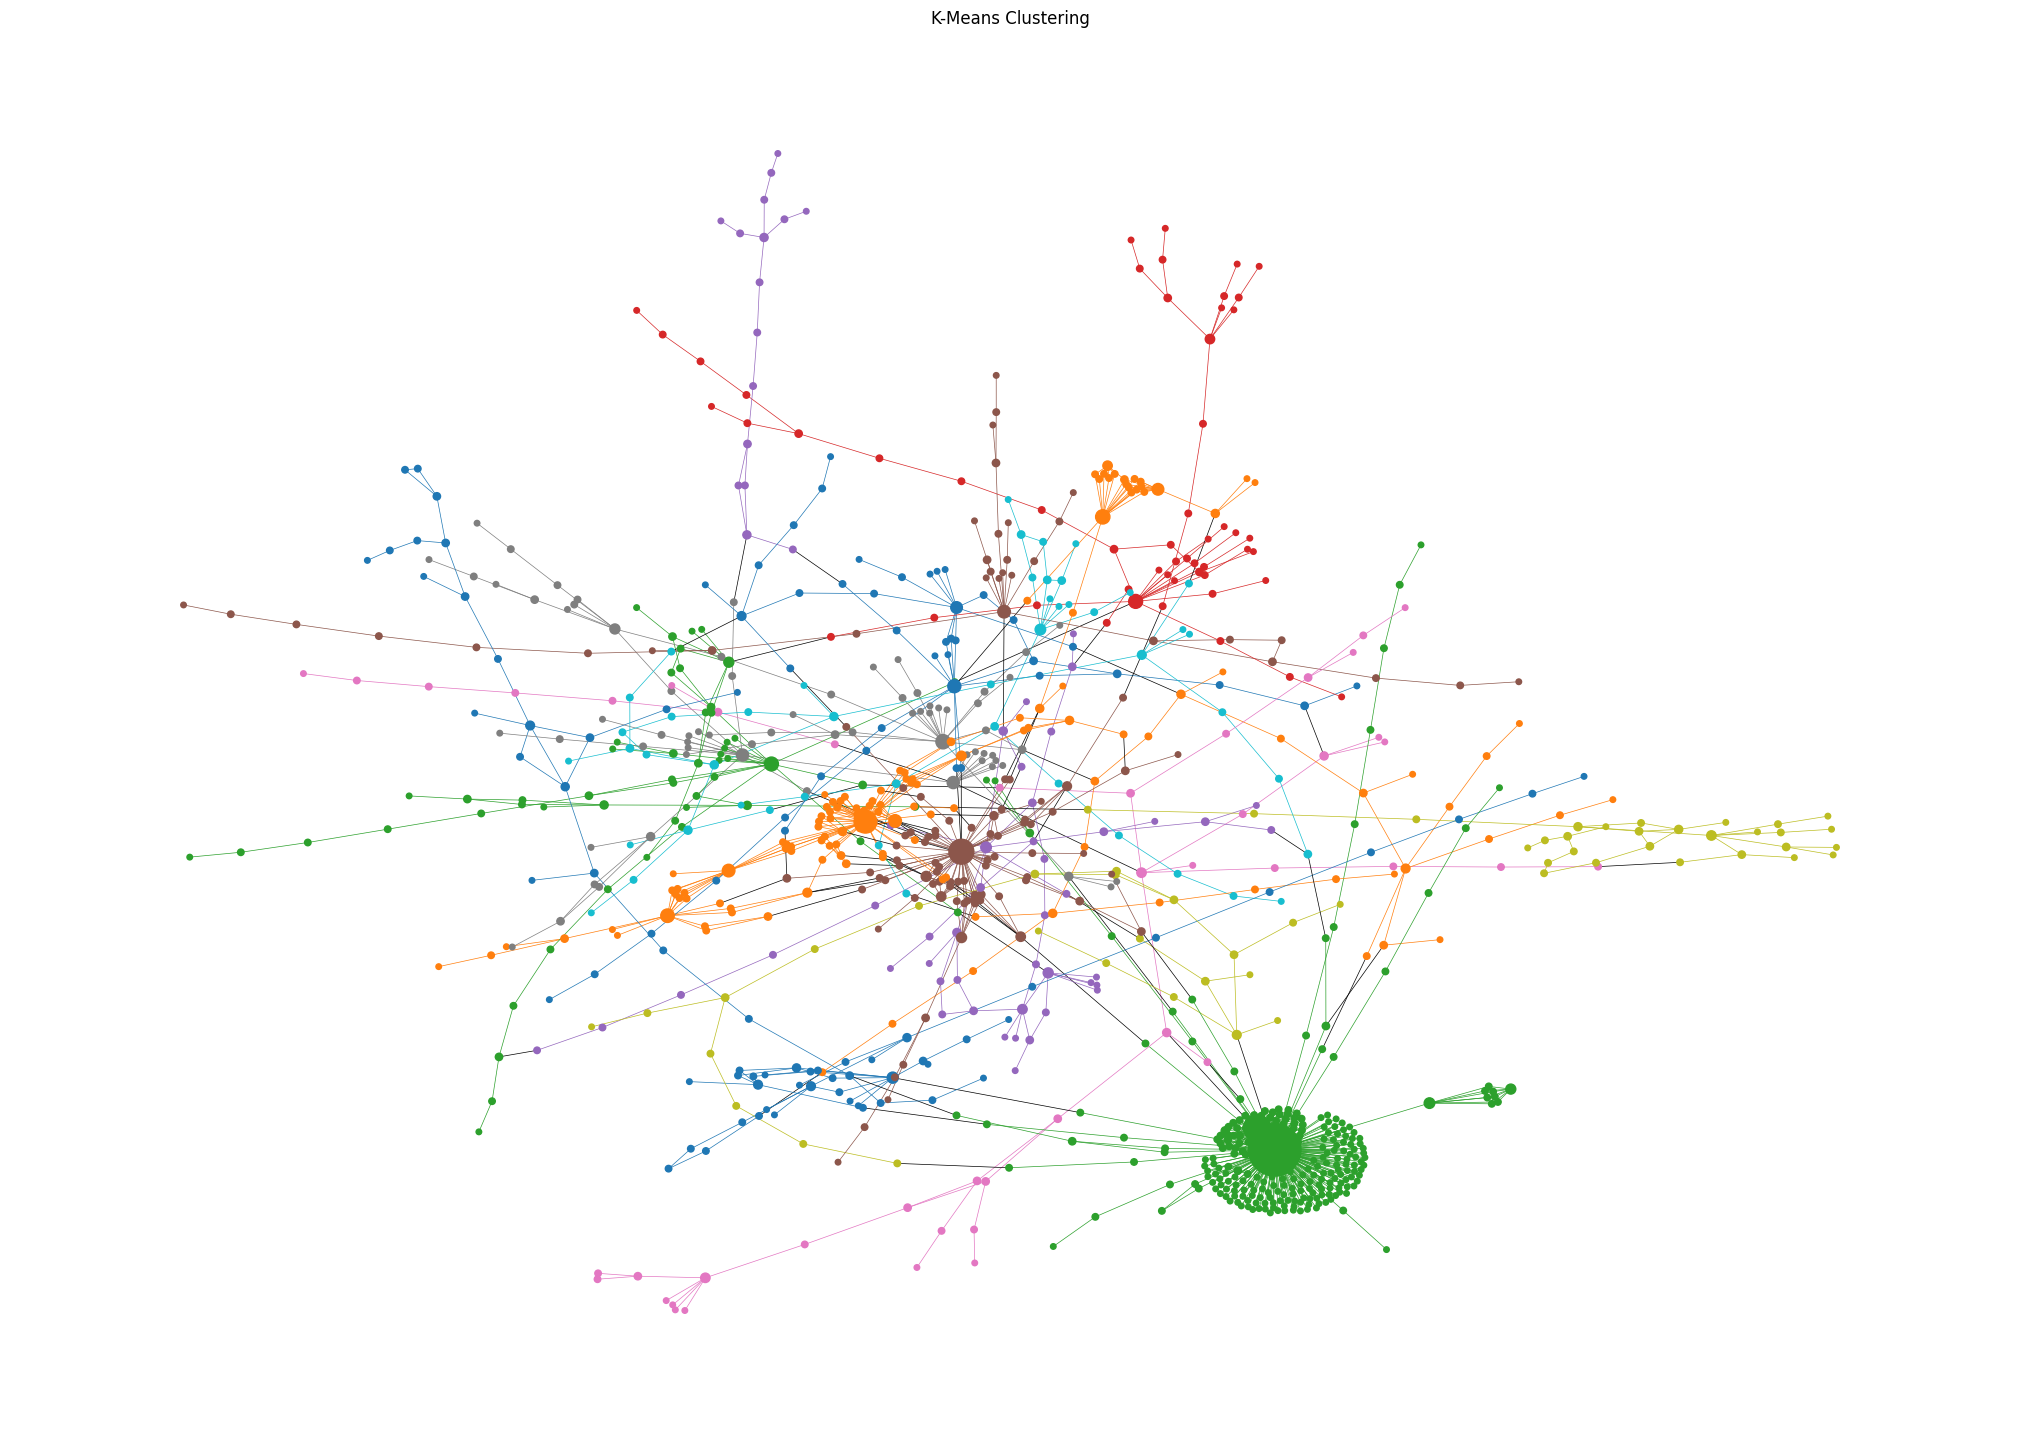

In [126]:
n_clusters = 22
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(node_vectors)
labels = kmeans.labels_

colors = plt.cm.tab10.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('K-Means Clustering')
plt.show()

In [127]:
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['K-Means Clustering',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.8270166171898805
Коэффициент силуэта: 0.34425068
Индекс Калински-Харабаша: 92.75589801195885
Индекс Дэвиcа-Боулдина: 1.356310313733747


## 8) DBSCAN

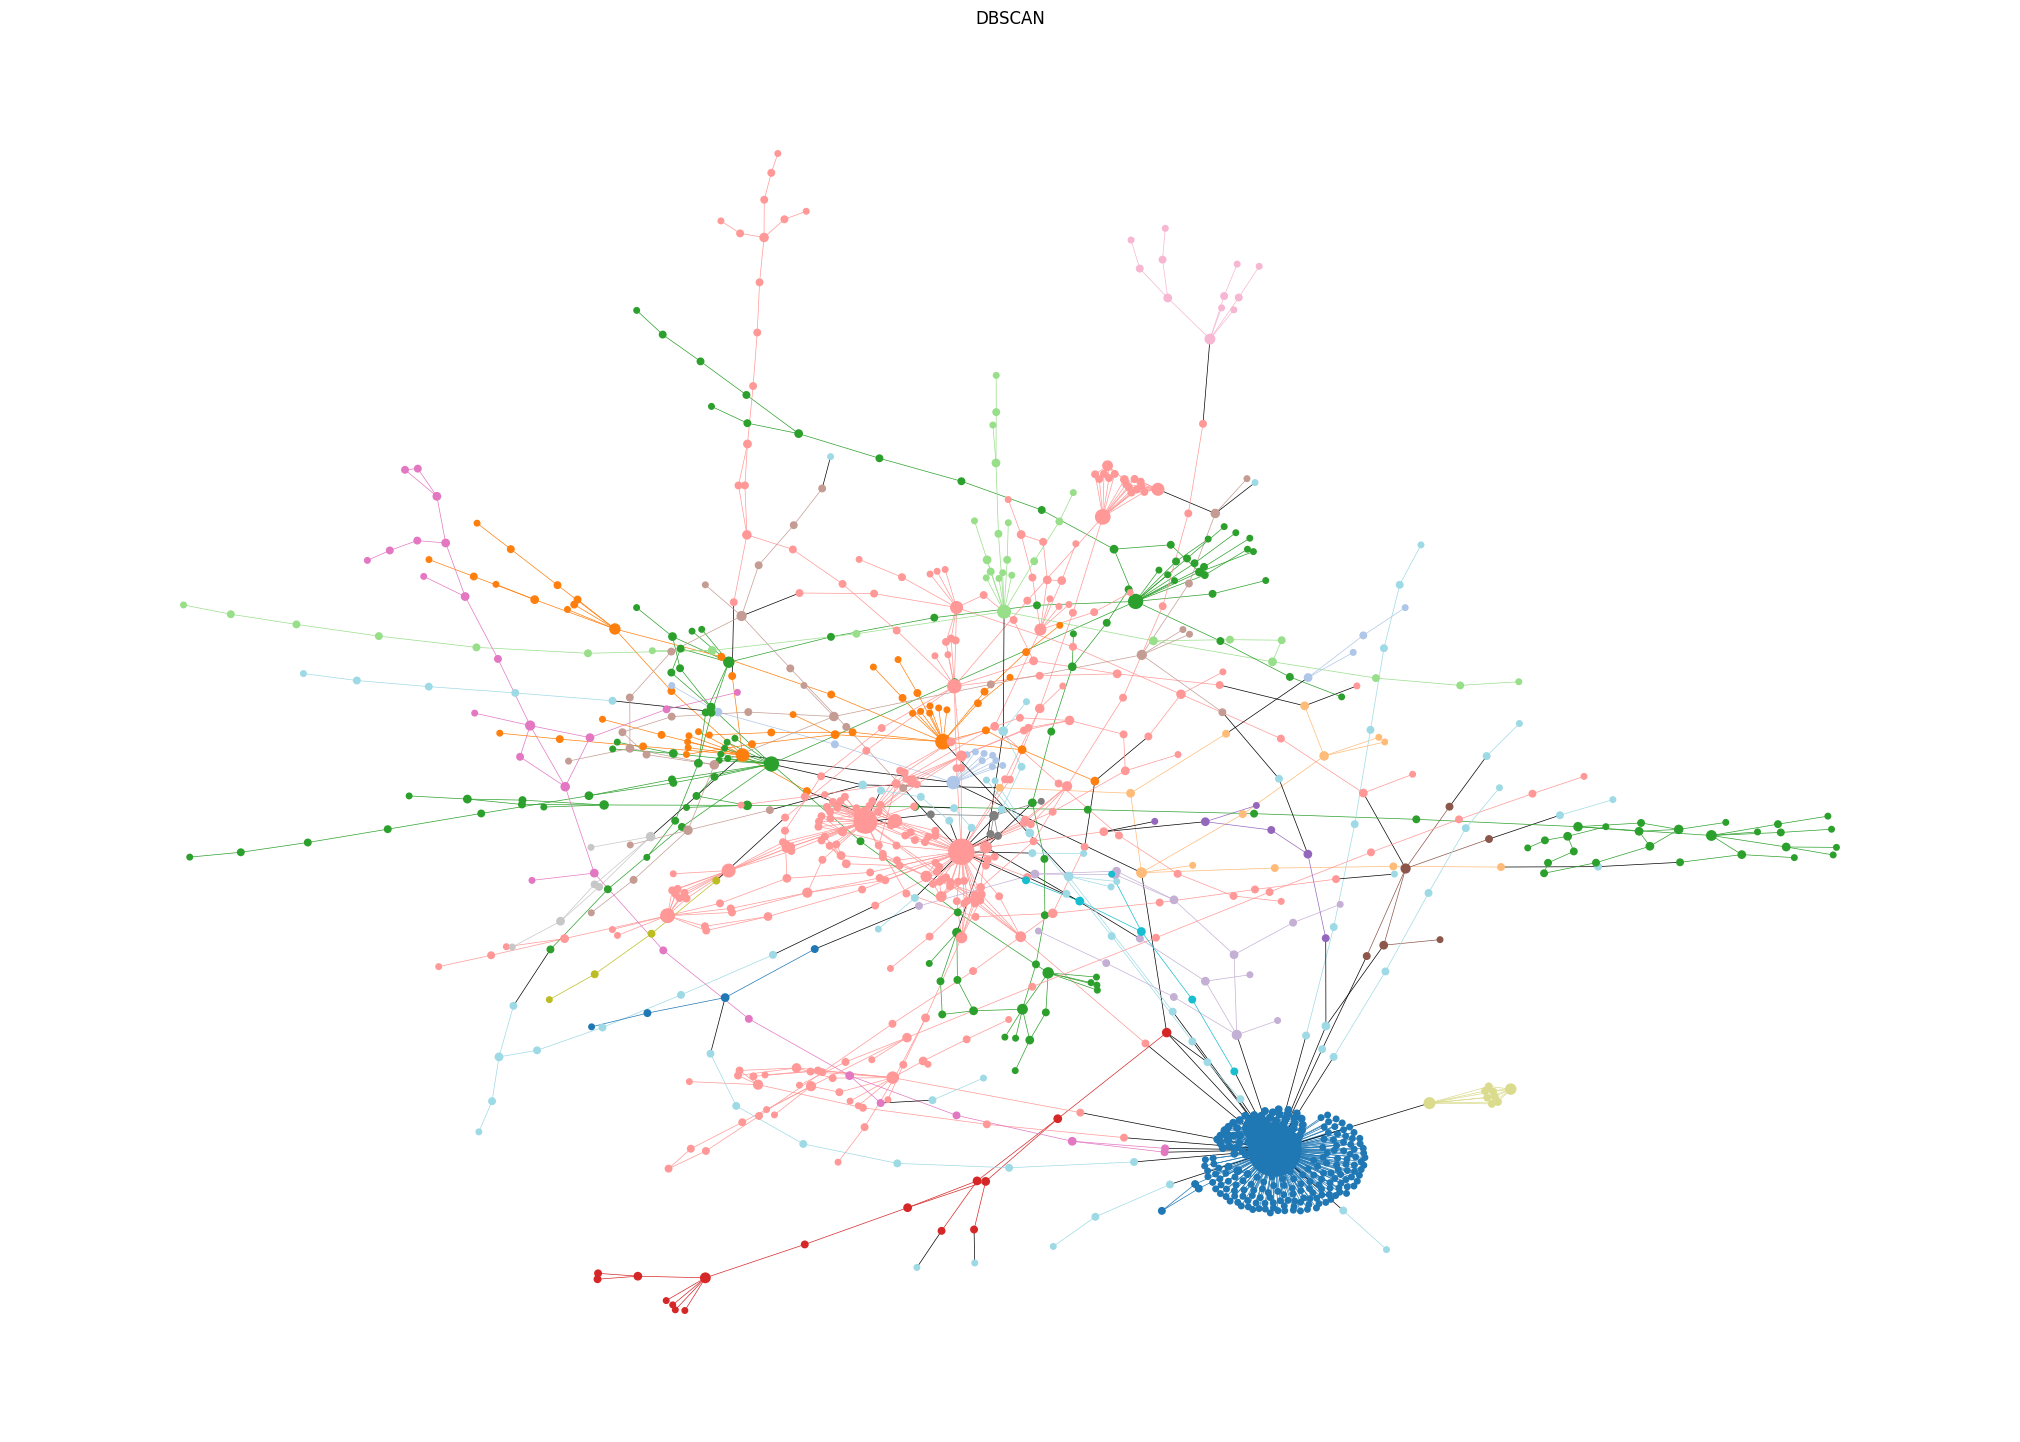

Количество кластеров: 22
Количество выбросов: 71


In [128]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan.fit(node_vectors)

# Получаем метки кластеров
labels = dbscan.labels_

# Создаем словарь для цветов узлов
colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

# Определяем цвета рёбер
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('DBSCAN')
plt.show()

# Определяем количество кластеров и выбросов
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_outliers = list(labels).count(-1)

print("Количество кластеров:", n_clusters)
print("Количество выбросов:", n_outliers)

In [129]:
clusters = {}
for i, label in enumerate(labels):
    node_name = list(G.nodes)[i]
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(node_name)

communities = [set(cluster) for cluster in clusters.values()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['DBSCAN',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.7386567389540043
Коэффициент силуэта: 0.16918157
Индекс Калински-Харабаша: 35.27997021279477
Индекс Дэвиcа-Боулдина: 1.7524842196403765


## 9) Agglomerative Clustering

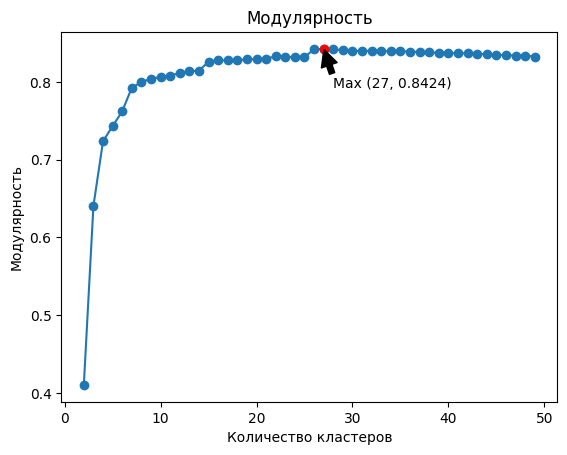

In [130]:
modularity_scores = []

for k in range(2, 50):
    kmeans = AgglomerativeClustering(n_clusters=k)
    kmeans.fit(node_vectors)
    labels = kmeans.labels_
    partition = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(k)]
    modularity_scores.append(modularity(G, partition))

plt.plot(range(2, 50), modularity_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Модулярность')
plt.title('Модулярность')

# Находим индекс максимального значения модулярности
max_modularity_index = modularity_scores.index(max(modularity_scores))

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index + 2, modularity_scores[max_modularity_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_modularity_index + 2}, {modularity_scores[max_modularity_index]:.4f})',
             xy=(max_modularity_index + 2, modularity_scores[max_modularity_index]),
             xytext=(max_modularity_index + 3, modularity_scores[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.02))

plt.show()

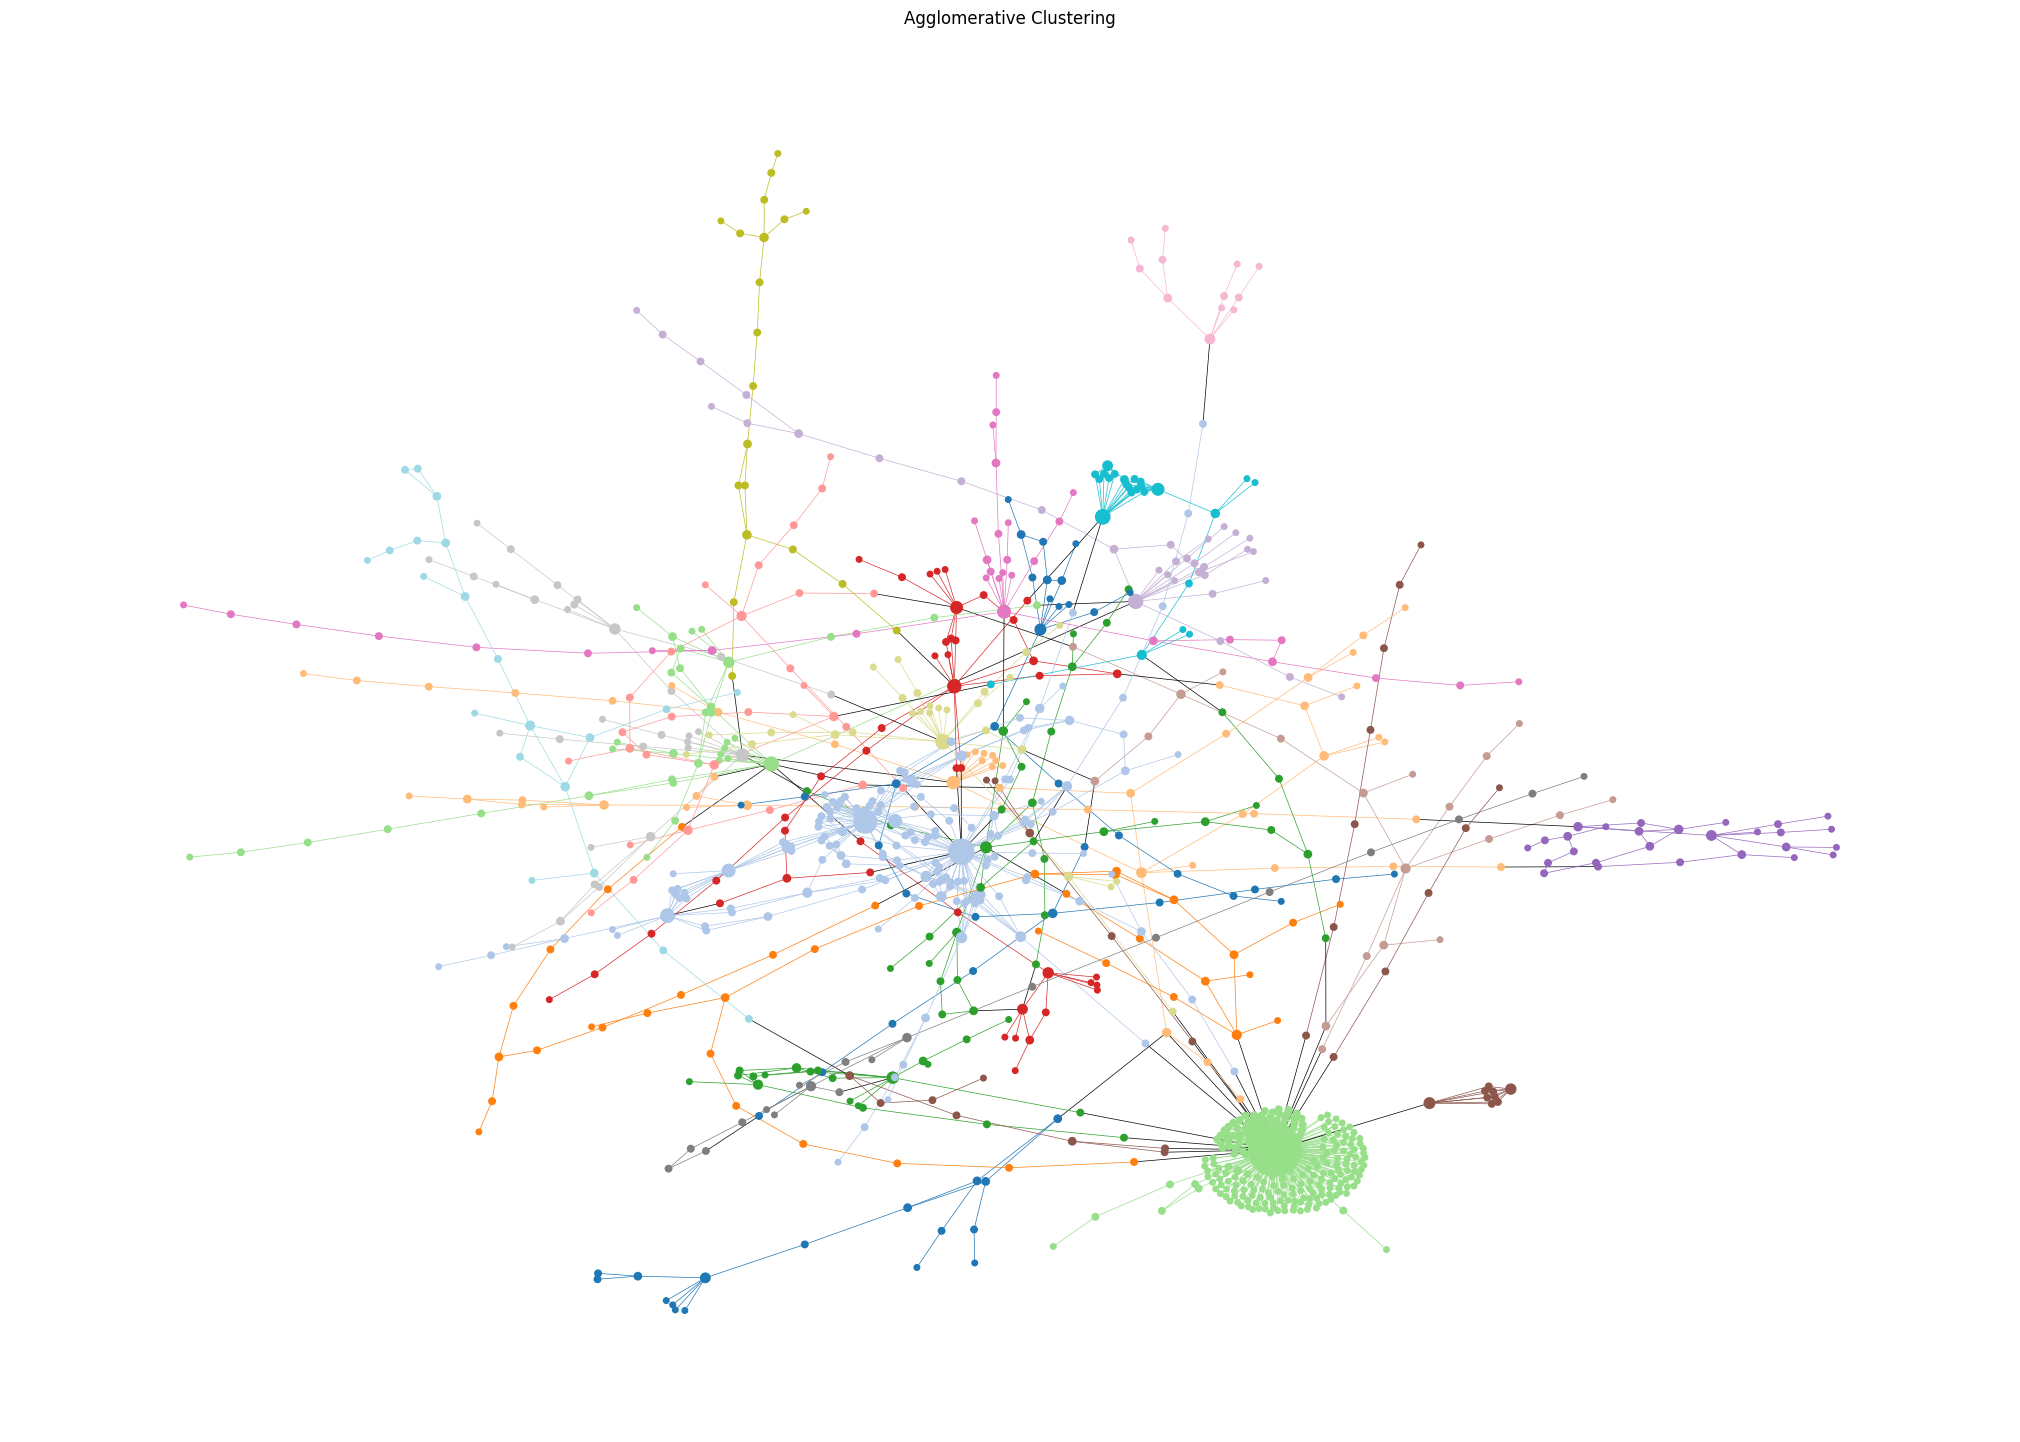

In [131]:
n_clusters = 27

hclust = AgglomerativeClustering(n_clusters)
labels = hclust.fit_predict(node_vectors)

colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]
node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Agglomerative Clustering')
plt.show()

In [132]:
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['Agglomerative Clustering',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.8424043021885724
Коэффициент силуэта: 0.3360169
Индекс Калински-Харабаша: 85.63659479967826
Индекс Дэвиcа-Боулдина: 1.3664175760890387


## 10) Spectral Clustering

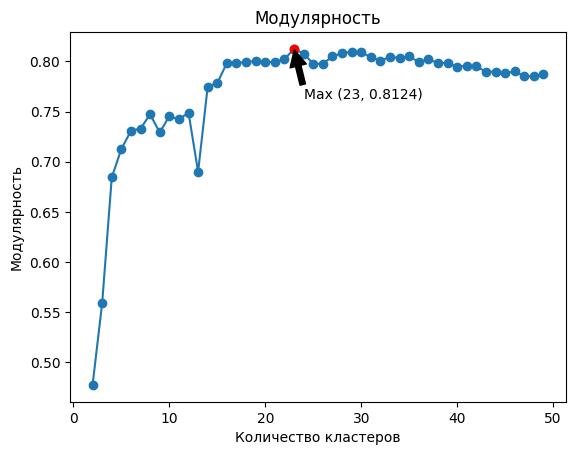

In [133]:
modularity_scores = []

for k in range(2, 50):
    kmeans = SpectralClustering(n_clusters=k,  affinity='nearest_neighbors')
    kmeans.fit(node_vectors)
    labels = kmeans.labels_
    partition = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(k)]
    modularity_scores.append(modularity(G, partition))

plt.plot(range(2, 50), modularity_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Модулярность')
plt.title('Модулярность')

# Находим индекс максимального значения модулярности
max_modularity_index = modularity_scores.index(max(modularity_scores))

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index + 2, modularity_scores[max_modularity_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_modularity_index + 2}, {modularity_scores[max_modularity_index]:.4f})',
             xy=(max_modularity_index + 2, modularity_scores[max_modularity_index]),
             xytext=(max_modularity_index + 3, modularity_scores[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.02))

plt.show()

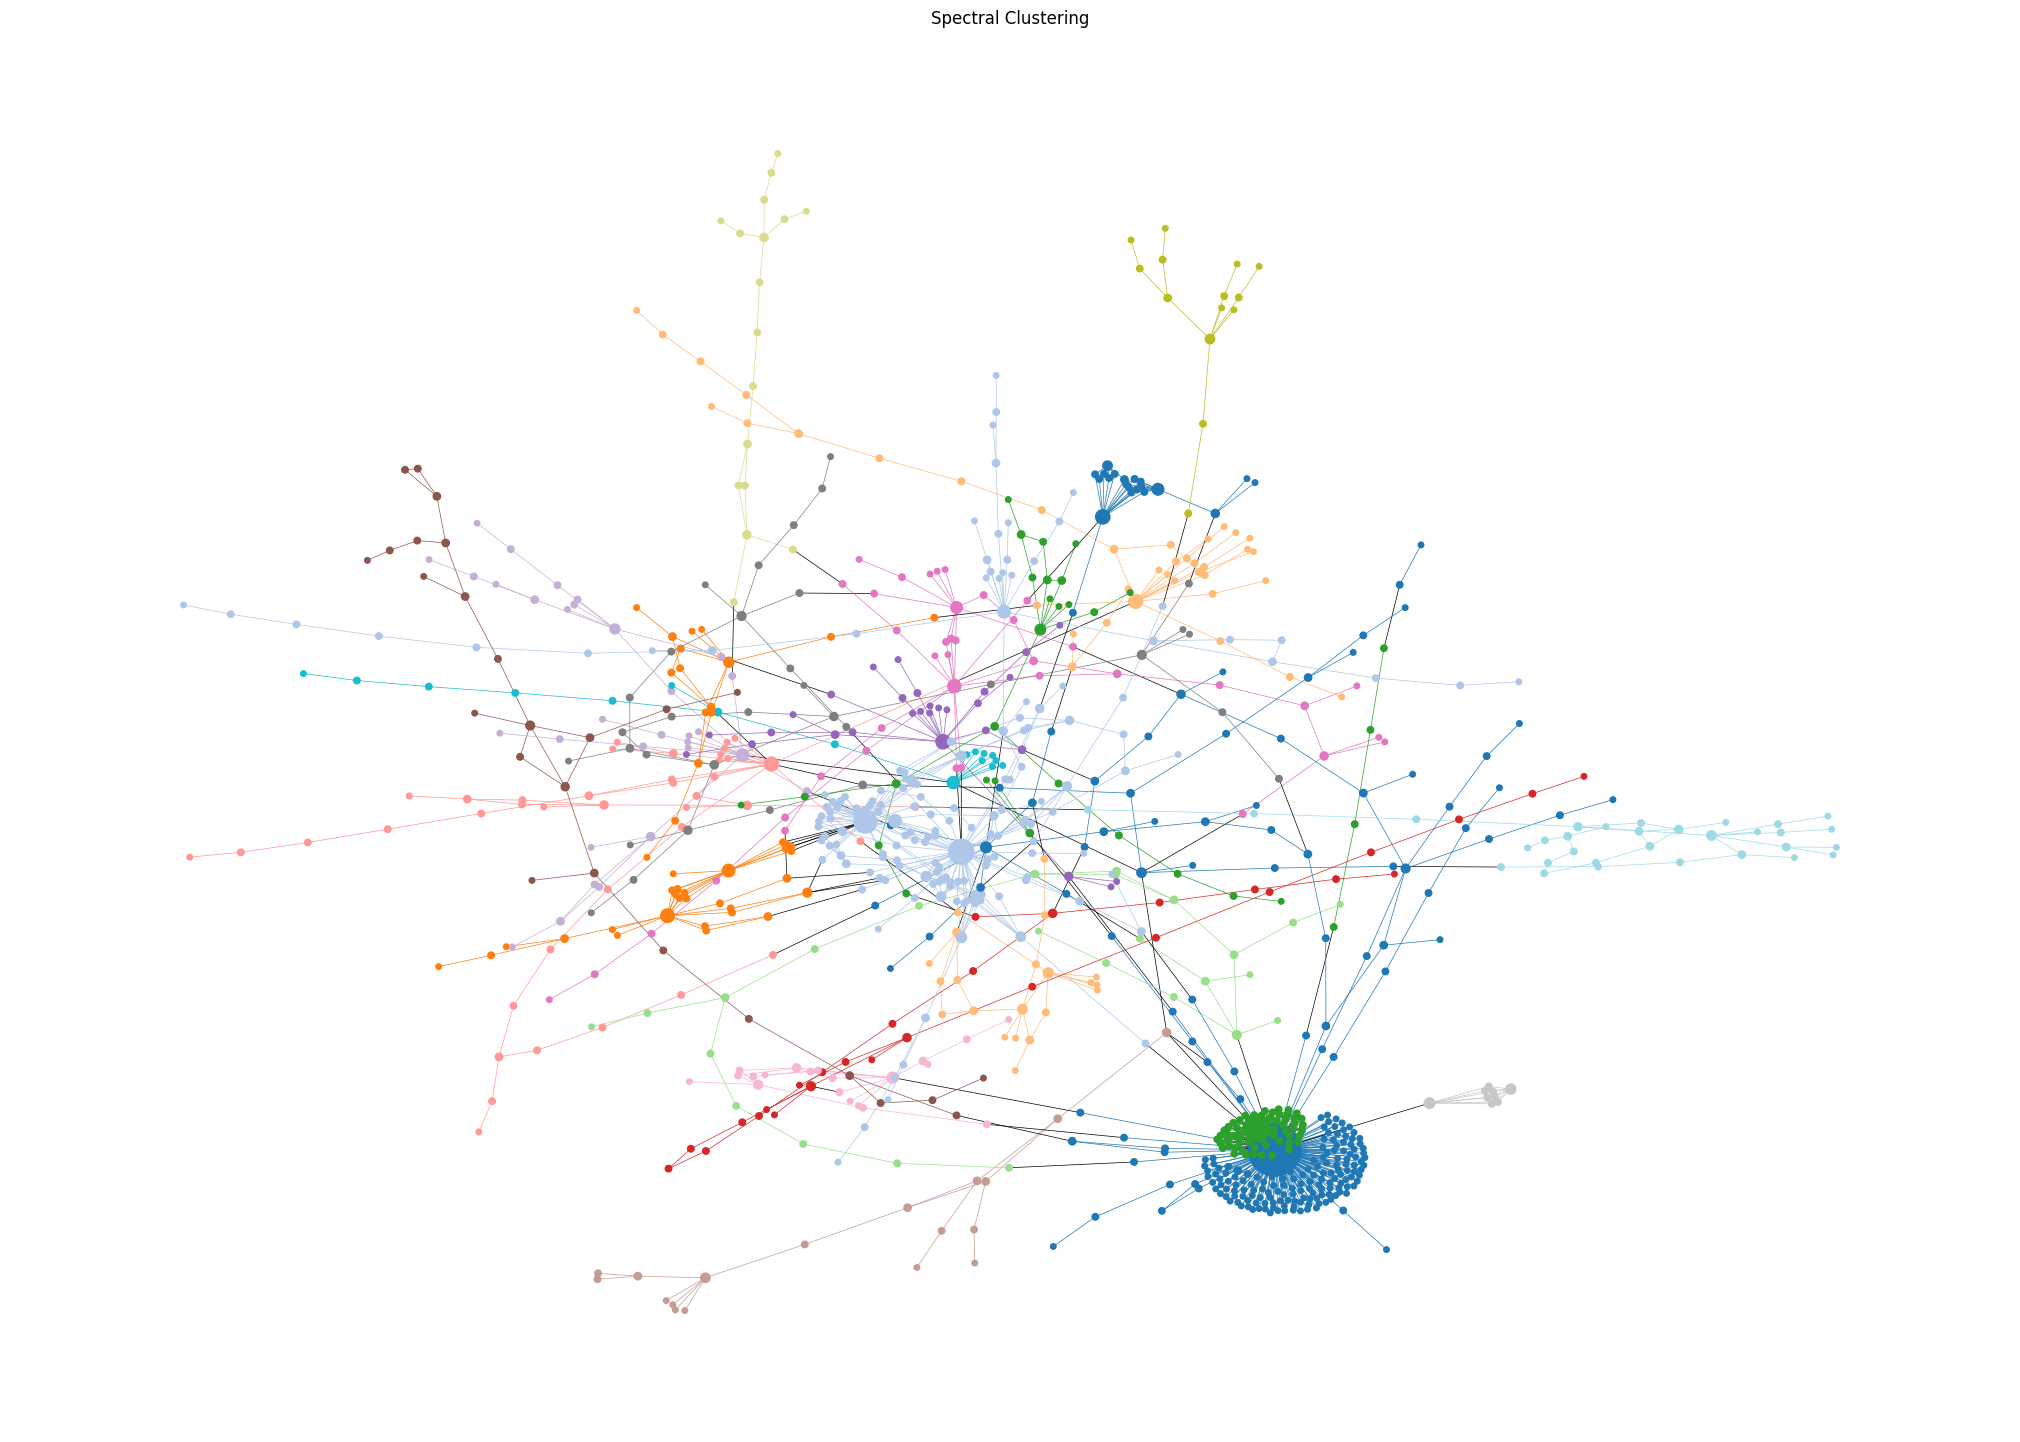

In [134]:
n_clusters = 25

spectral_cluster = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
labels = spectral_cluster.fit_predict(node_vectors)

colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Spectral Clustering')
plt.show()

In [135]:
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['Spectral Clustering',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.7976483696927047
Коэффициент силуэта: 0.18187267
Индекс Калински-Харабаша: 78.17657415479933
Индекс Дэвиcа-Боулдина: 1.3759246402439067


## 11) Affinity Propagation

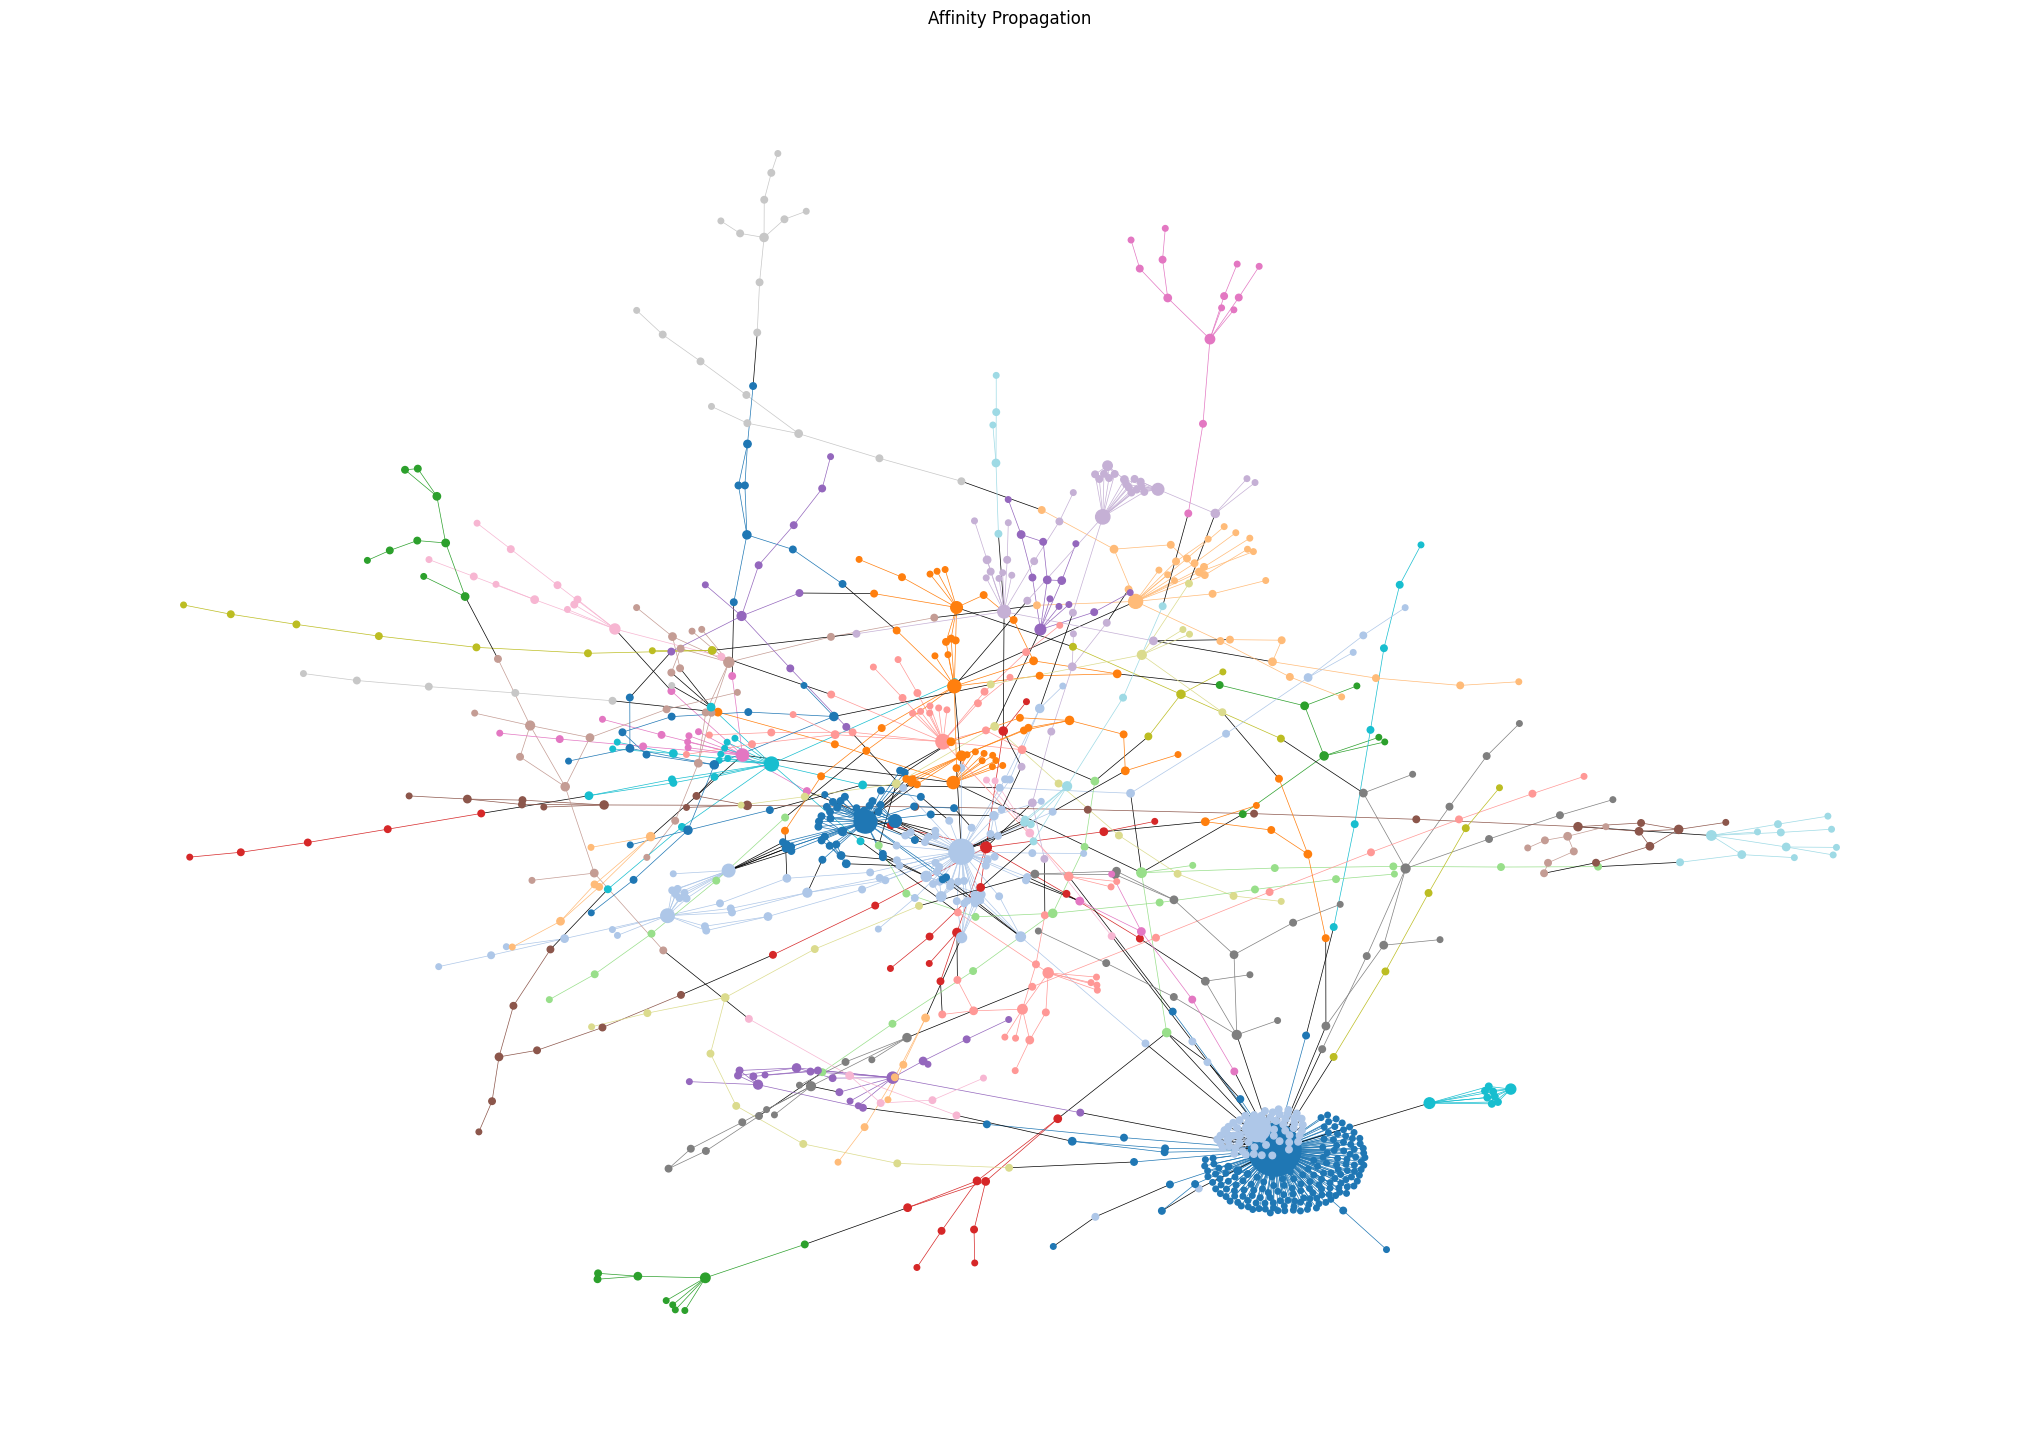

In [136]:
affinity_cluster = AffinityPropagation()
labels = affinity_cluster.fit_predict(node_vectors)

colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Affinity Propagation')
plt.show()

In [137]:
n_clusters = len(affinity_cluster.cluster_centers_indices_)
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['Affinity Propagation',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.7829816032635807
Коэффициент силуэта: 0.29097548
Индекс Калински-Харабаша: 84.2241134399618
Индекс Дэвиcа-Боулдина: 1.0193270373270678


## 12) Mean Shift Clustering

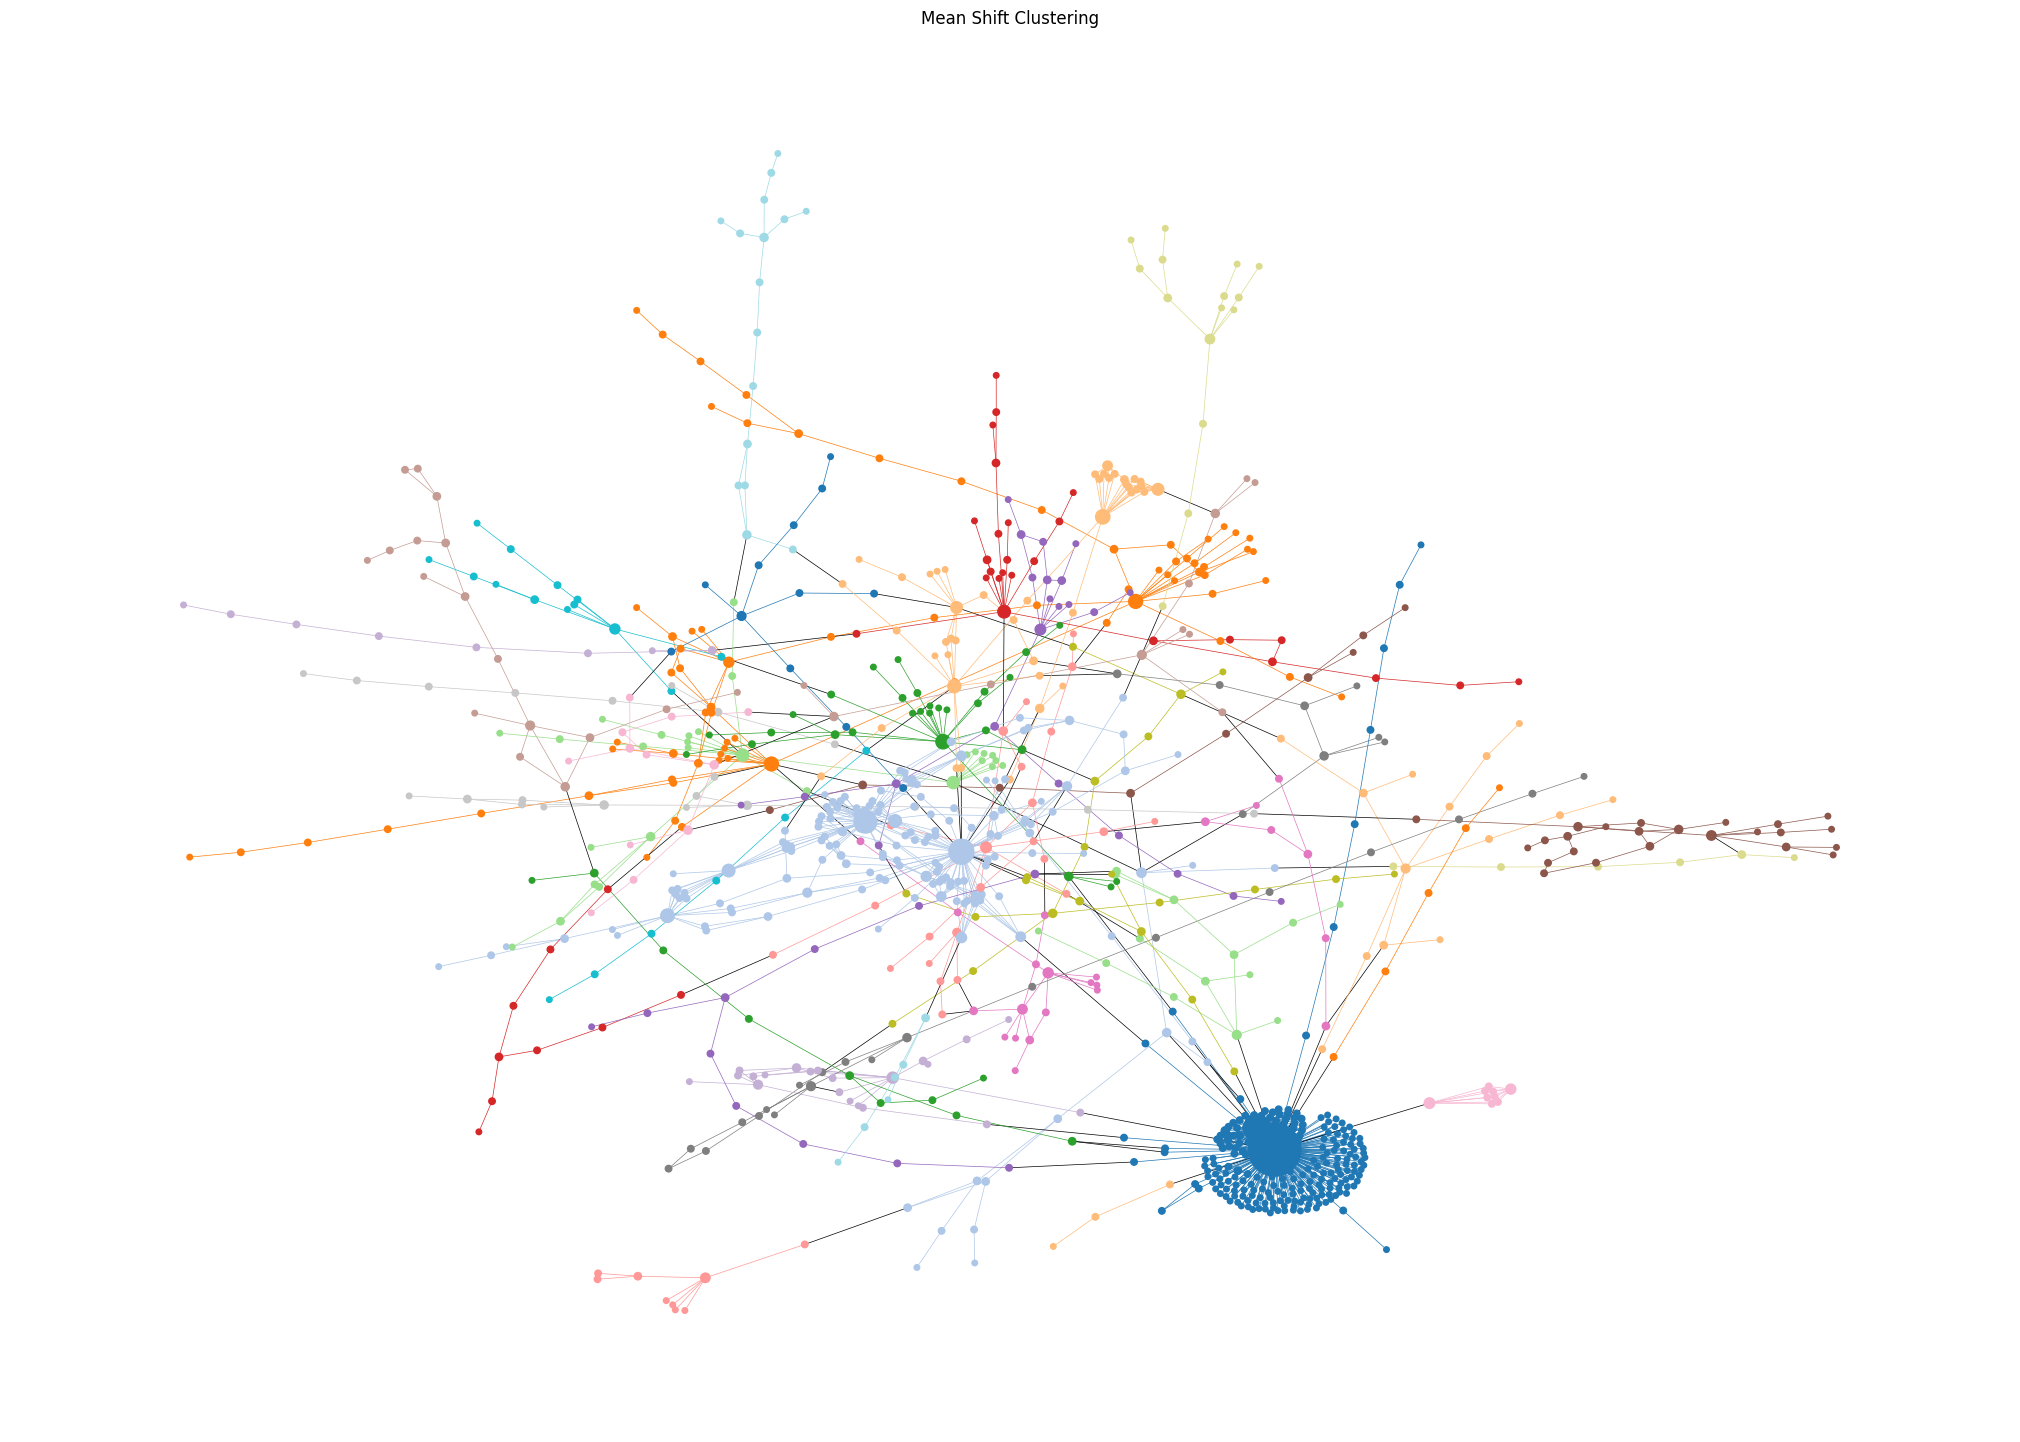

In [138]:
meanshift = MeanShift(bandwidth=2)
labels = meanshift.fit_predict(node_vectors)

colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Mean Shift Clustering')
plt.show()

In [139]:
n_clusters = len(np.unique(labels))
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['Mean Shift Clustering',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.8284705876008749
Коэффициент силуэта: 0.37794864
Индекс Калински-Харабаша: 75.39524410886838
Индекс Дэвиcа-Боулдина: 1.032922473381741


## 13) Birch

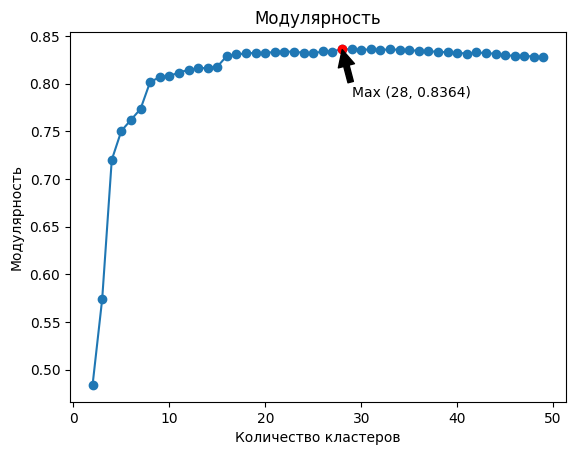

In [140]:
modularity_scores = []

for k in range(2, 50):
    kmeans = Birch(n_clusters=k)
    kmeans.fit(node_vectors)
    labels = kmeans.labels_
    partition = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(k)]
    modularity_scores.append(modularity(G, partition))

plt.plot(range(2, 50), modularity_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Модулярность')
plt.title('Модулярность')

# Находим индекс максимального значения модулярности
max_modularity_index = modularity_scores.index(max(modularity_scores))

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index + 2, modularity_scores[max_modularity_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_modularity_index + 2}, {modularity_scores[max_modularity_index]:.4f})',
             xy=(max_modularity_index + 2, modularity_scores[max_modularity_index]),
             xytext=(max_modularity_index + 3, modularity_scores[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.02))

plt.show()

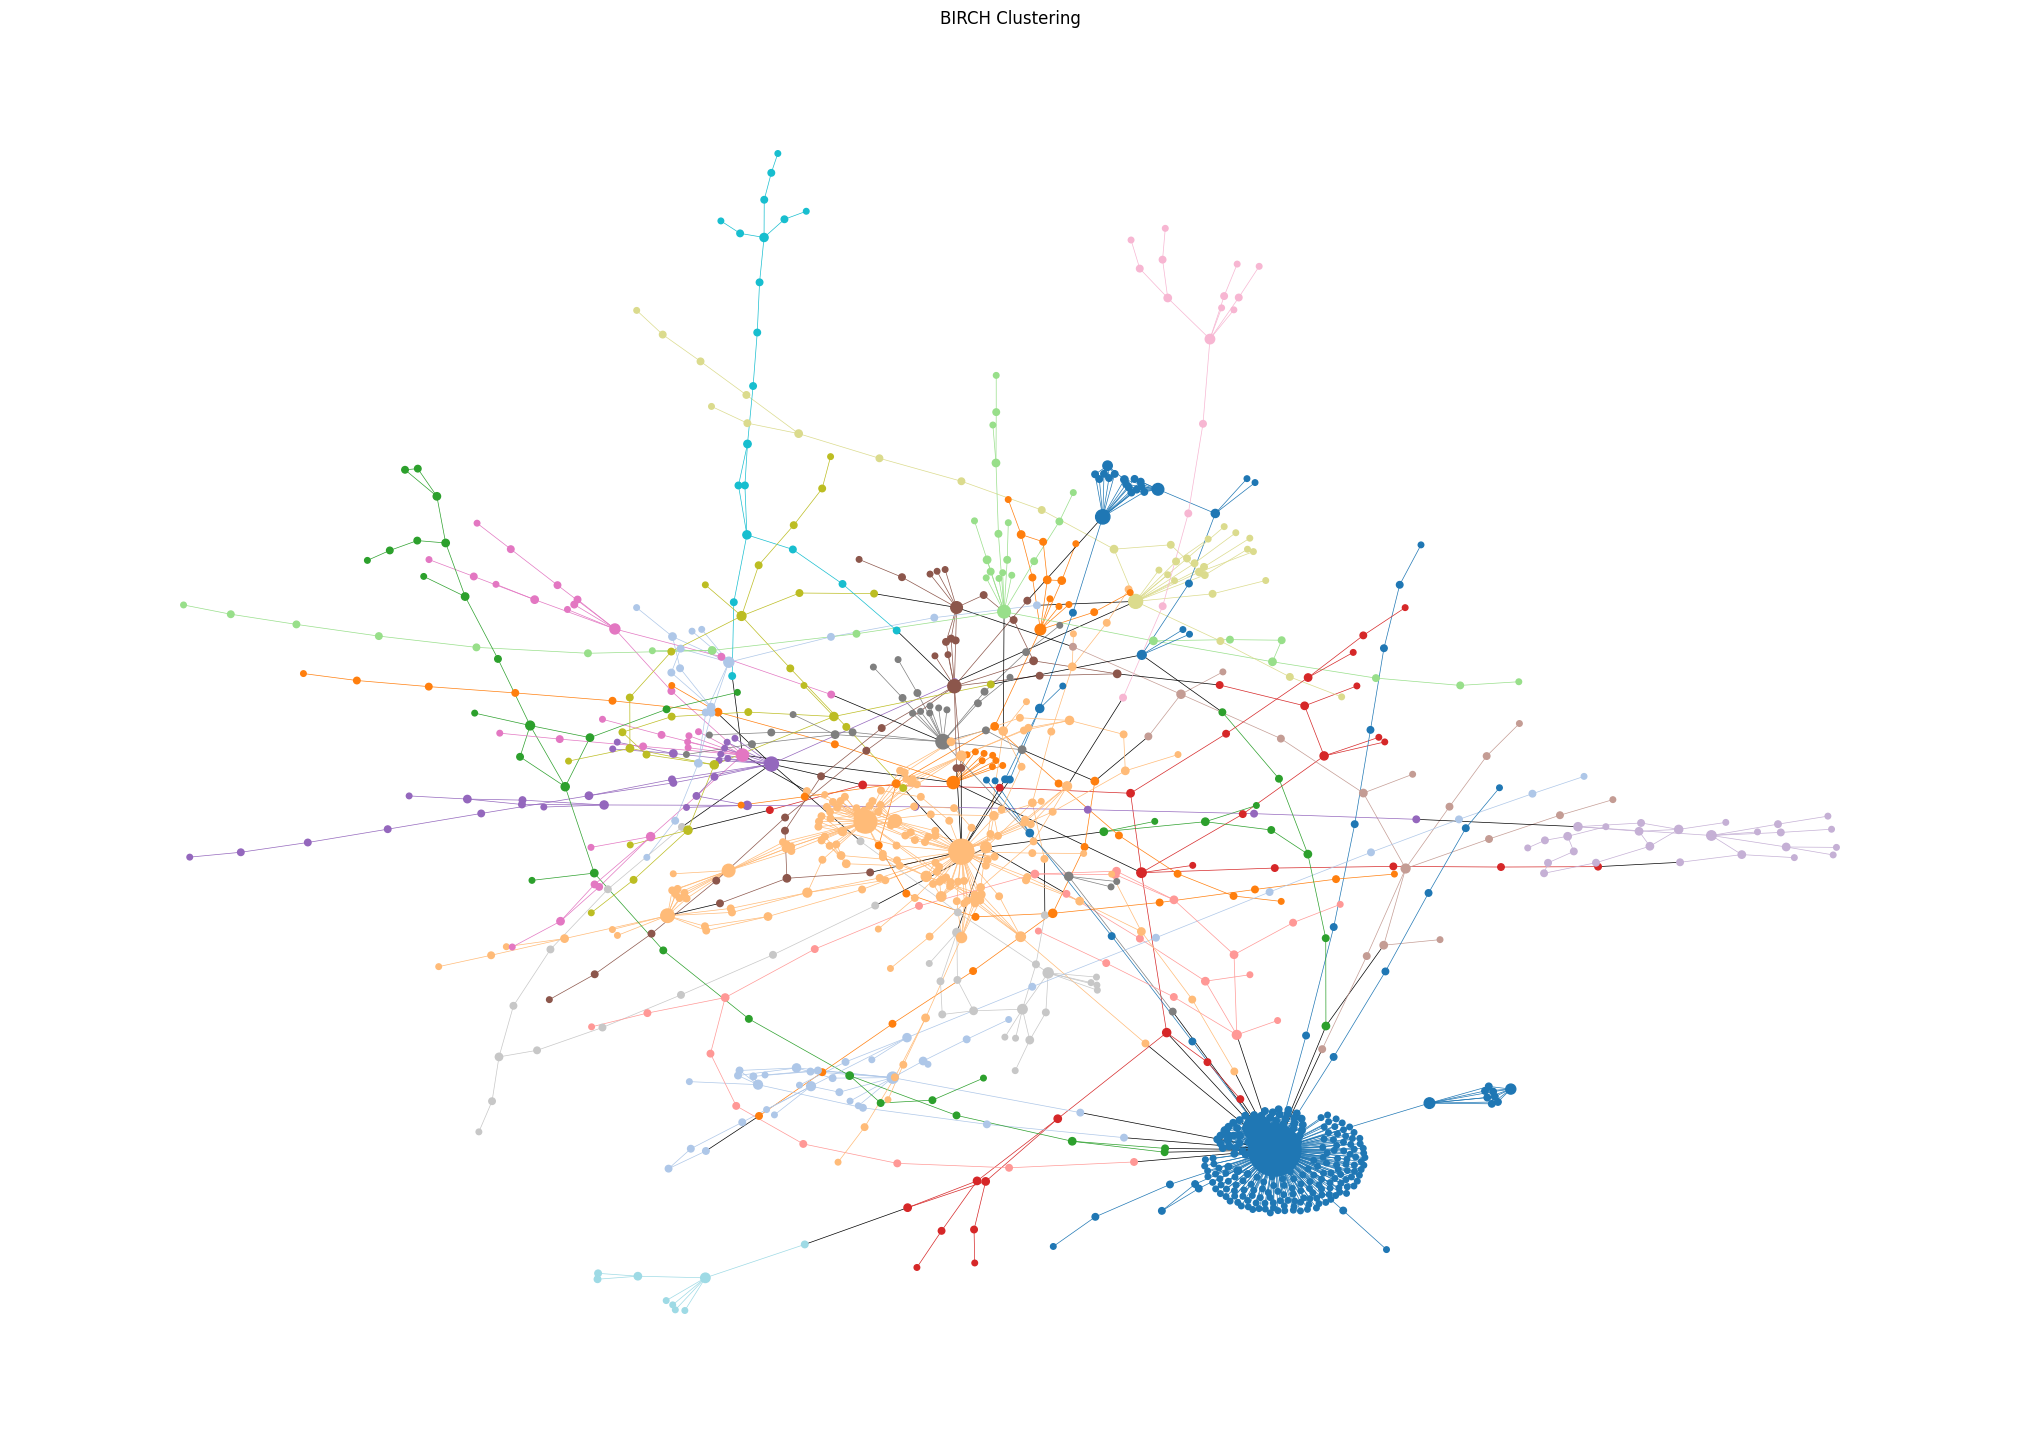

In [141]:
birch = Birch(n_clusters=25)

# Применяем кластеризацию к векторам узлов
labels = birch.fit_predict(node_vectors)

# Создаем словарь цветов для узлов
colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

# Создаем цвета для ребер
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

# Создаем словарь степеней узлов
node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('BIRCH Clustering')
plt.show()

In [142]:
n_clusters = len(np.unique(labels))
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

# Вычисляем коэффициент силуэта
silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

# Вычисляем индекс Калински-Харабаша
CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

# Вычисляем индекс Дэвиcа-Боулдина
DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['BIRCH',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.8317718486522631
Коэффициент силуэта: 0.35473505
Индекс Калински-Харабаша: 85.00525269760247
Индекс Дэвиcа-Боулдина: 1.2676447091140424


## 14) OPTICS

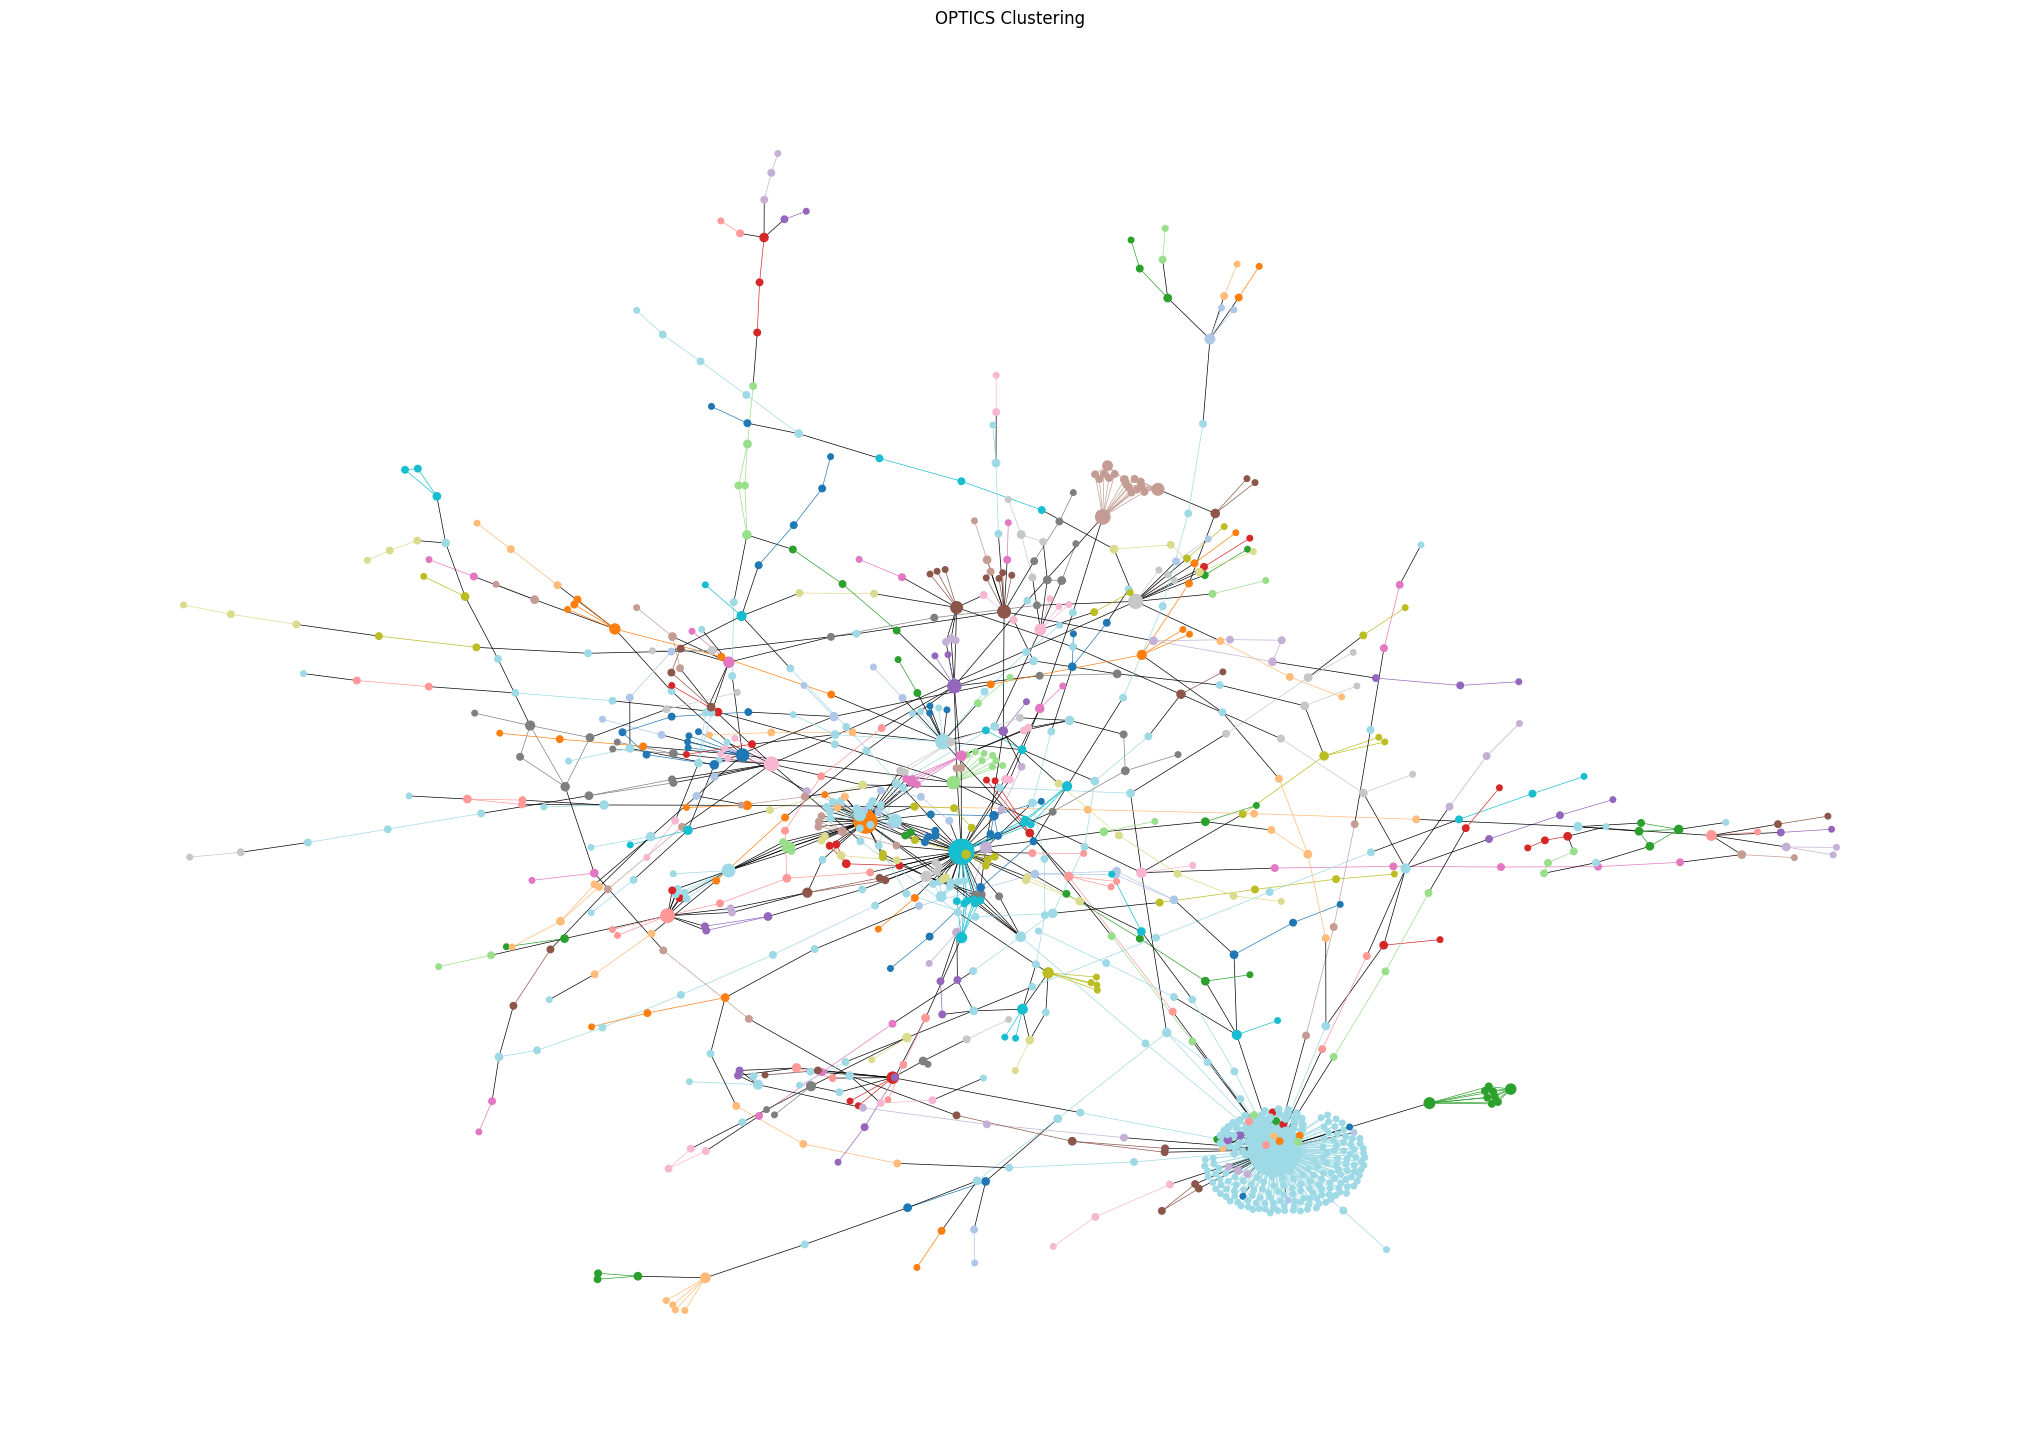

Количество кластеров: 228
Количество выбросов: 322


In [143]:
optics = OPTICS(min_samples=2, max_eps=1.5)

labels = optics.fit_predict(node_vectors)

colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(
    colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

edge_colors = ['black'if node_color_dict[u] !=
               node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors,
        edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('OPTICS Clustering')
plt.show()

# Определяем количество кластеров и выбросов
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_outliers = list(labels).count(-1)

print("Количество кластеров:", n_clusters)
print("Количество выбросов:", n_outliers)

In [144]:
clusters = {}
for i, label in enumerate(labels):
    node_name = list(G.nodes)[i]
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(node_name)

communities = [set(cluster) for cluster in clusters.values()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

results.loc[len(results)] = ['OPTICS',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5)]

Модулярность: 0.4887888568031264
Коэффициент силуэта: 0.0694496
Индекс Калински-Харабаша: 12.005642932122235
Индекс Дэвиcа-Боулдина: 0.8564546502218957


# Результаты

In [145]:
results

Метод  Количество кластеров  Модулярность  \
0               Лувенский алгоритм                    29       0.84733   
1         Алгоритм Гирвана-Ньюмена                    28       0.84423   
2   Greedy Modularity Maximization                    31       0.84373   
3                 Asynchronous LPA                   214       0.66195   
4                  Synchronous LPA                   209       0.67478   
5                Fluid Communities                    18       0.82197   
6               K-Means Clustering                    22       0.82702   
7                           DBSCAN                    23       0.73866   
8         Agglomerative Clustering                    27       0.84240   
9              Spectral Clustering                    25       0.79765   
10            Affinity Propagation                    64       0.78298   
11           Mean Shift Clustering                    44       0.82847   
12                           BIRCH                    25       0.83177   
13                          OPTICS                   229       0.48879   

    Коэффициент силуэта  Индекс Калински-Харабаша  Индекс Дэвиcа-Боулдина  
0               0.32695                  75.03647                 1.24784  
1               0.31369                  72.70709                 1.30147  
2               0.33803                  72.64585                 1.21378  
3               0.30108                  50.68581                 0.88078  
4               0.33172                  53.38016                 0.84666  
5               0.26267                  72.43379                 1.66371  
6               0.34425                  92.75590                 1.35631  
7               0.16918                  35.27997                 1.75248  
8               0.33602                  85.63659                 1.36642  
9               0.18187                  78.17657                 1.37592  
10              0.29098                  84.22411                 1.01933  
11              0.37795                  75.39524                 1.03292  
12              0.35474                  85.00525                 1.26764  
13              0.06945                  12.00564                 0.85645